# AIT Project - Final Project

**Alan Gaugler**  
**U885853**  
**October 26, 2023**  


# <span style="color: darkblue;">Introduction</span>

This project is concerned with article classification. A news category dataset with over 200,000 article headlines and descriptions will be used in this project. The aim is to read and interpret the headlines and descriptions and categorize them into one of 42 topic categories.

This project continues on from the midsemester report. A good baseline was established using a Logistic Regression Model which had an overall accuracy of 60.51%. To improve on this accuracy various aspects were investigated including:

1. Merging similar categories
2. Addressing class imbalance and processing time by evaluating undersampling. (This was done in a separate notebook)
3. The use of word embedding techniques including GloVe and word2vec
4. Using Recurrent Neural Networks such as GRUs and LSTMs.

**Import the required libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter

import os
import re
import string
from gensim.models import Phrases
from gensim.models.phrases import Phraser
import nltk  # Natural language toolkit

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import StratifiedKFold

import joblib
import time
import warnings
import random
#warnings.filterwarnings('ignore')

### Exploratory Data Analysis

In [2]:
# Load the JSON file
df = pd.read_json("News_Category_Dataset_v3.json", lines=True)

In [3]:
# Set Pandas option to display the entire content in a column
pd.set_option('display.max_colwidth', None)

In [4]:
# Display the header
df.head()

link  \
0                                                      https://www.huffpost.com/entry/covid-boosters-uptake-us_n_632d719ee4b087fae6feaac9   
1  https://www.huffpost.com/entry/american-airlines-passenger-banned-flight-attendant-punch-justice-department_n_632e25d3e4b0e247890329fe   
2                                     https://www.huffpost.com/entry/funniest-tweets-cats-dogs-september-17-23_n_632de332e4b0695c1d81dc02   
3                                                     https://www.huffpost.com/entry/funniest-parenting-tweets_l_632d7d15e4b0d12b5403e479   
4                    https://www.huffpost.com/entry/amy-cooper-loses-discrimination-lawsuit-franklin-templeton_n_632c6463e4b09d8701bd227e   

                                                                                    headline  \
0               Over 4 Million Americans Roll Up Sleeves For Omicron-Targeted COVID Boosters   
1  American Airlines Flyer Charged, Banned For Life After Punching Flight Attendant On Video   
2                      23 Of The Funniest Tweets About Cats And Dogs This Week (Sept. 17-23)   
3                                   The Funniest Tweets From Parents This Week (Sept. 17-23)   
4              Woman Who Called Cops On Black Bird-Watcher Loses Lawsuit Against Ex-Employer   

    category  \
0  U.S. NEWS   
1  U.S. NEWS   
2     COMEDY   
3  PARENTING   
4  U.S. NEWS   

                                                                                                                                                 short_description  \
0       Health experts said it is too early to predict whether demand would match up with the 171 million doses of the new boosters the U.S. ordered for the fall.   
1  He was subdued by passengers and crew when he fled to the back of the aircraft after the confrontation, according to the U.S. attorney's office in Los Angeles.   
2                                                                                                 "Until you have a dog you don't understand what could be eaten."   
3  "Accidentally put grown-up toothpaste on my toddler’s toothbrush and he screamed like I was cleaning his teeth with a Carolina Reaper dipped in Tabasco sauce."   
4     Amy Cooper accused investment firm Franklin Templeton of unfairly firing her and branding her a racist after video of the Central Park encounter went viral.   

                authors       date  
0  Carla K. Johnson, AP 2022-09-23  
1        Mary Papenfuss 2022-09-23  
2         Elyse Wanshel 2022-09-23  
3      Caroline Bologna 2022-09-23  
4        Nina Golgowski 2022-09-22

The dataset consists of 6 columns:

**link:** The URL of the news article.<br>
**headline:** The headline of the article.<br>
**category:** The category of type or article. This is the target variable.<br>
**short_description:** A short description of the article. This will be key in identifying the article category.<br>
**authors:** The names of the article's authors.<br>
**date:** The date of the article's publication.<br>

In [5]:
df.shape

(209527, 6)

This is a large dataset with 209527 articles.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209527 entries, 0 to 209526
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   link               209527 non-null  object        
 1   headline           209527 non-null  object        
 2   category           209527 non-null  object        
 3   short_description  209527 non-null  object        
 4   authors            209527 non-null  object        
 5   date               209527 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(5)
memory usage: 9.6+ MB


All columns are objects except for the date which is datetime.

In [7]:
df.describe()

C:\Users\alang\AppData\Local\Temp\ipykernel_19772\3627053830.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df.describe()


link  \
count                                                                                                                                                                                    209527   
unique                                                                                                                                                                                   209486   
top     https://www.huffingtonpost.comhttps://www.washingtonpost.com/politics/divisions-within-gop-over-trumps-candidacy-are-growing/2016/02/28/97b16010-de3a-11e5-8d98-4b3d9215ade1_story.html   
freq                                                                                                                                                                                          2   
first                                                                                                                                                                                       NaN   
last                                                                                                                                                                                        NaN   

              headline  category short_description authors  \
count           209527    209527            209527  209527   
unique          207996        42            187022   29169   
top     Sunday Roundup  POLITICS                             
freq                90     35602             19712   37418   
first              NaN       NaN               NaN     NaN   
last               NaN       NaN               NaN     NaN   

                       date  
count                209527  
unique                 3890  
top     2014-03-25 00:00:00  
freq                    100  
first   2012-01-28 00:00:00  
last    2022-09-23 00:00:00

In [8]:
# Find the number of missing values in each column
df.isna().sum()

link                 0
headline             0
category             0
short_description    0
authors              0
date                 0
dtype: int64

There are no missing values in the dataset.

In [9]:
# Are there any duplicate headlines?
df['headline'].value_counts()

Sunday Roundup                                                                  90
The 20 Funniest Tweets From Women This Week                                     80
Weekly Roundup of eBay Vintage Clothing Finds (PHOTOS)                          59
Weekly Roundup of eBay Vintage Home Finds (PHOTOS)                              54
Watch The Top 9 YouTube Videos Of The Week                                      46
                                                                                ..
Here Are The Manufacturers Bringing The Most Jobs Back to America                1
2016 Campaigns Meet With White House To Prep For Obama's Last Days In Office     1
If Toddlers Could Calmly Articulate Their Feelings                               1
Snapchat's Bob Marley Filter Called Out For Being 'Digital Blackface'            1
Dwight Howard Rips Teammates After Magic Loss To Hornets                         1
Name: headline, Length: 207996, dtype: int64

Yes. There are many headlines that are duplicates. They all appear to be weekly articles.

In [10]:
# Are there any duplicate short descriptions?
df['short_description'].value_counts()

                                                                                                                                 19712
Welcome to the HuffPost Rise Morning Newsbrief, a short wrap-up of the news to help you start your day.                            192
The stress and strain of constantly being connected can sometimes take your life -- and your well-being -- off course. GPS         125
Want more? Be sure to check out HuffPost Style on Twitter, Facebook, Tumblr, Pinterest and Instagram at @HuffPostStyle. -- Do       91
Do you have a home story idea or tip? Email us at homesubmissions@huffingtonpost.com. (PR pitches sent to this address will         75
                                                                                                                                 ...  
The "Selma" director is teaming up with Oprah for her first ever TV series.                                                          1
It's one of the thorniest moral dilemmas in tech right 

**There are duplicate short descriptions.**

**The headline and the short description columns will be merged togther for the analysis**<br>
This will reduce the number of duplicates.

In [11]:
# Display all the categories
df['category'].unique()

array(['U.S. NEWS', 'COMEDY', 'PARENTING', 'WORLD NEWS', 'CULTURE & ARTS',
       'TECH', 'SPORTS', 'ENTERTAINMENT', 'POLITICS', 'WEIRD NEWS',
       'ENVIRONMENT', 'EDUCATION', 'CRIME', 'SCIENCE', 'WELLNESS',
       'BUSINESS', 'STYLE & BEAUTY', 'FOOD & DRINK', 'MEDIA',
       'QUEER VOICES', 'HOME & LIVING', 'WOMEN', 'BLACK VOICES', 'TRAVEL',
       'MONEY', 'RELIGION', 'LATINO VOICES', 'IMPACT', 'WEDDINGS',
       'COLLEGE', 'PARENTS', 'ARTS & CULTURE', 'STYLE', 'GREEN', 'TASTE',
       'HEALTHY LIVING', 'THE WORLDPOST', 'GOOD NEWS', 'WORLDPOST',
       'FIFTY', 'ARTS', 'DIVORCE'], dtype=object)

In [12]:
df['category'].nunique()

42

There are 42 unique values. These will be the categories.

In [13]:
# Display the number of articles per category
df['category'].value_counts()

POLITICS          35602
WELLNESS          17945
ENTERTAINMENT     17362
TRAVEL             9900
STYLE & BEAUTY     9814
PARENTING          8791
HEALTHY LIVING     6694
QUEER VOICES       6347
FOOD & DRINK       6340
BUSINESS           5992
COMEDY             5400
SPORTS             5077
BLACK VOICES       4583
HOME & LIVING      4320
PARENTS            3955
THE WORLDPOST      3664
WEDDINGS           3653
WOMEN              3572
CRIME              3562
IMPACT             3484
DIVORCE            3426
WORLD NEWS         3299
MEDIA              2944
WEIRD NEWS         2777
GREEN              2622
WORLDPOST          2579
RELIGION           2577
STYLE              2254
SCIENCE            2206
TECH               2104
TASTE              2096
MONEY              1756
ARTS               1509
ENVIRONMENT        1444
FIFTY              1401
GOOD NEWS          1398
U.S. NEWS          1377
ARTS & CULTURE     1339
COLLEGE            1144
LATINO VOICES      1130
CULTURE & ARTS     1074
EDUCATION       

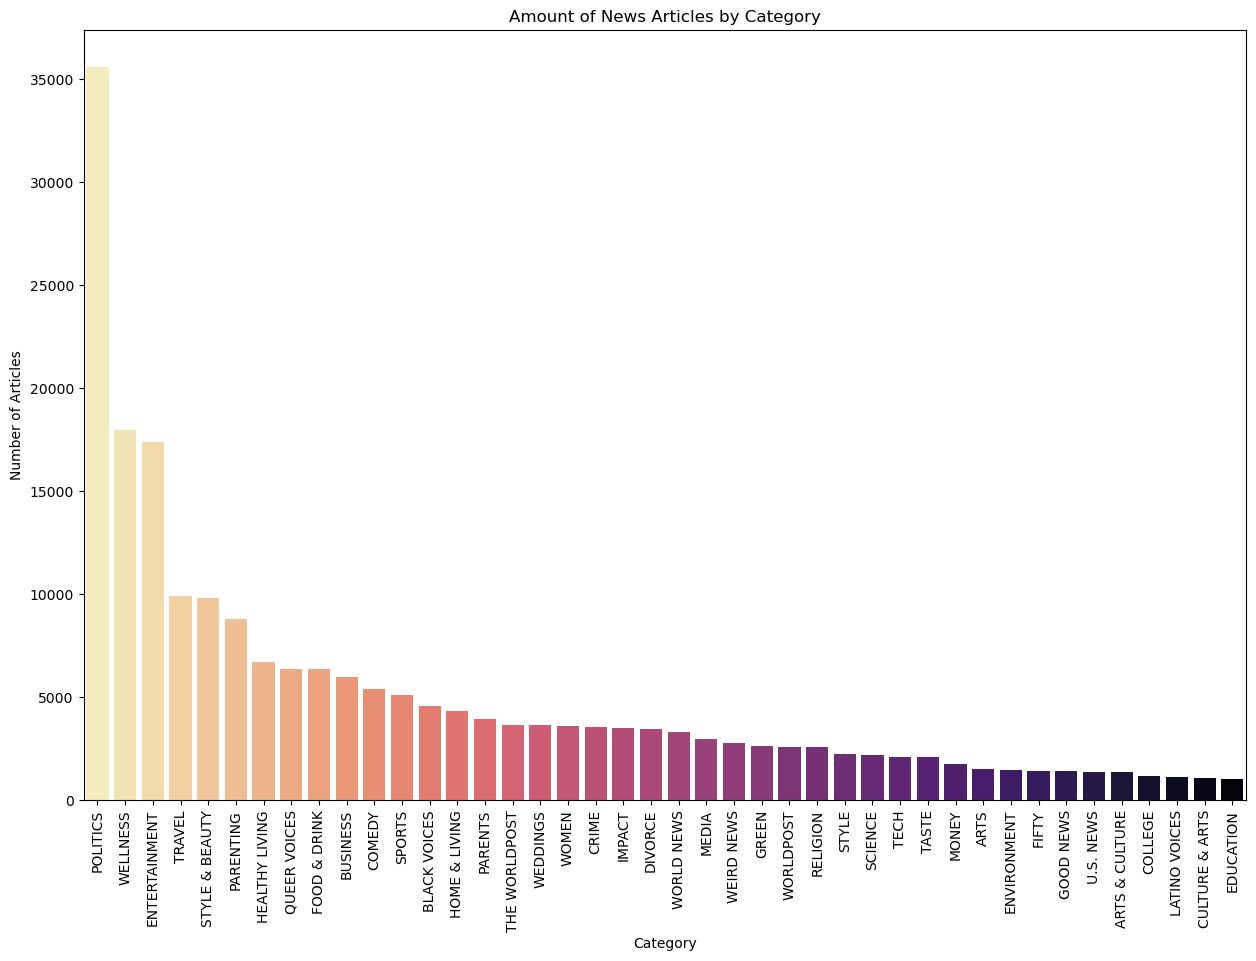

In [14]:
# Plot the distribution of news articles by news category.
plt.figure(figsize=(15, 10))
ax = sns.countplot(x=df['category'], order=df['category'].value_counts().index, palette="magma_r")
plt.title('Amount of News Articles by Category')
plt.ylabel('Number of Articles')
plt.xlabel('Category')
plt.xticks(rotation=90)
plt.show()


Politics is by far the most common category in this dataset, followed by wellness and entertainment. This dataset is clearly very imbalanced. This will produce challenges in predicting the minority categories.

In [15]:
# Add extra columns to count the number of words in the headline and the short description
df['word_count_headline'] = df['headline'].apply(lambda text: len(str(text).split()))
df['word_count_description'] = df['short_description'].apply(lambda text: len(str(text).split()))

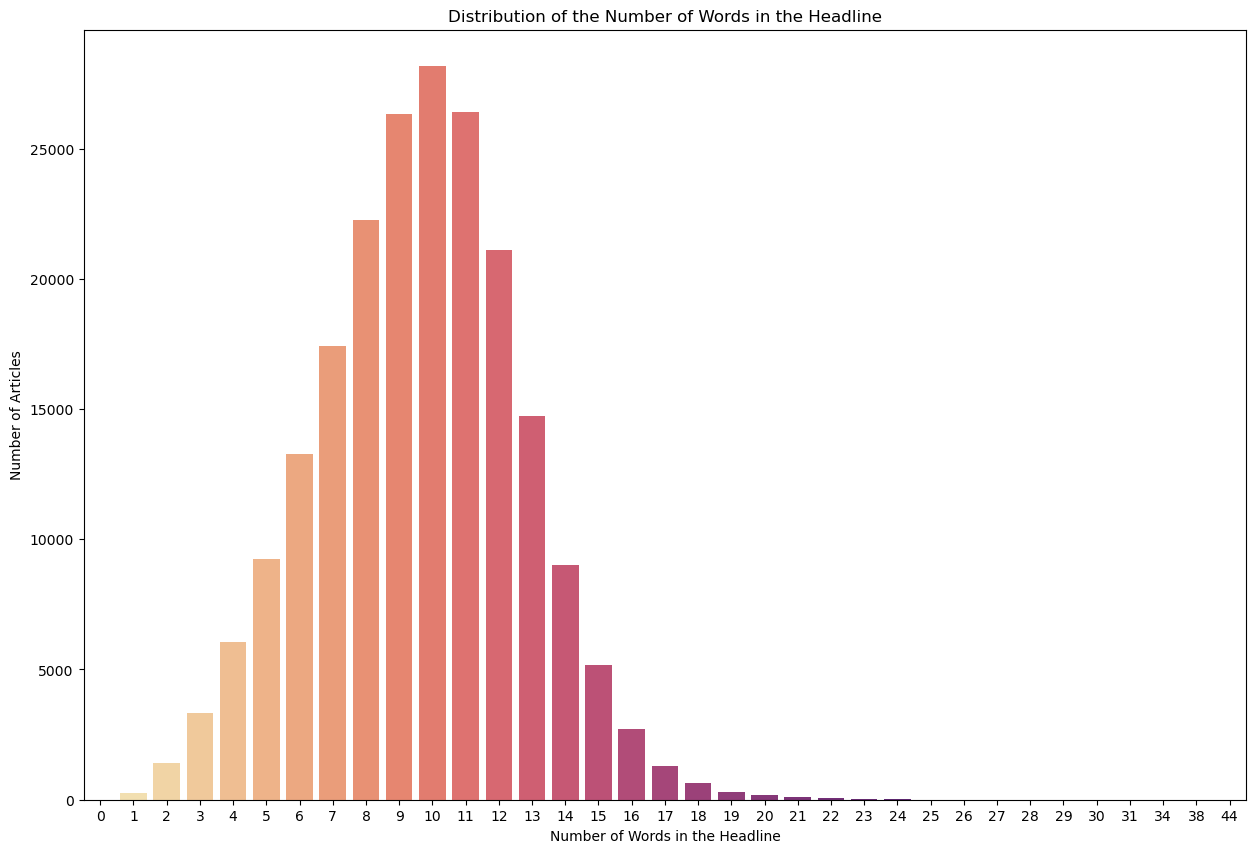

In [16]:
# Plot the Distribution of the Number of Words in the Headline.
plt.figure(figsize=(15, 10))
ax = sns.countplot(x=df['word_count_headline'], 
                   order=df['word_count_headline'].value_counts().sort_index(ascending=True).index, 
                   palette="magma_r")
plt.title('Distribution of the Number of Words in the Headline')
plt.ylabel('Number of Articles')
plt.xlabel('Number of Words in the Headline')
plt.show()

The number of words per headline has a fairly normalized distribution, centred on 10 words.

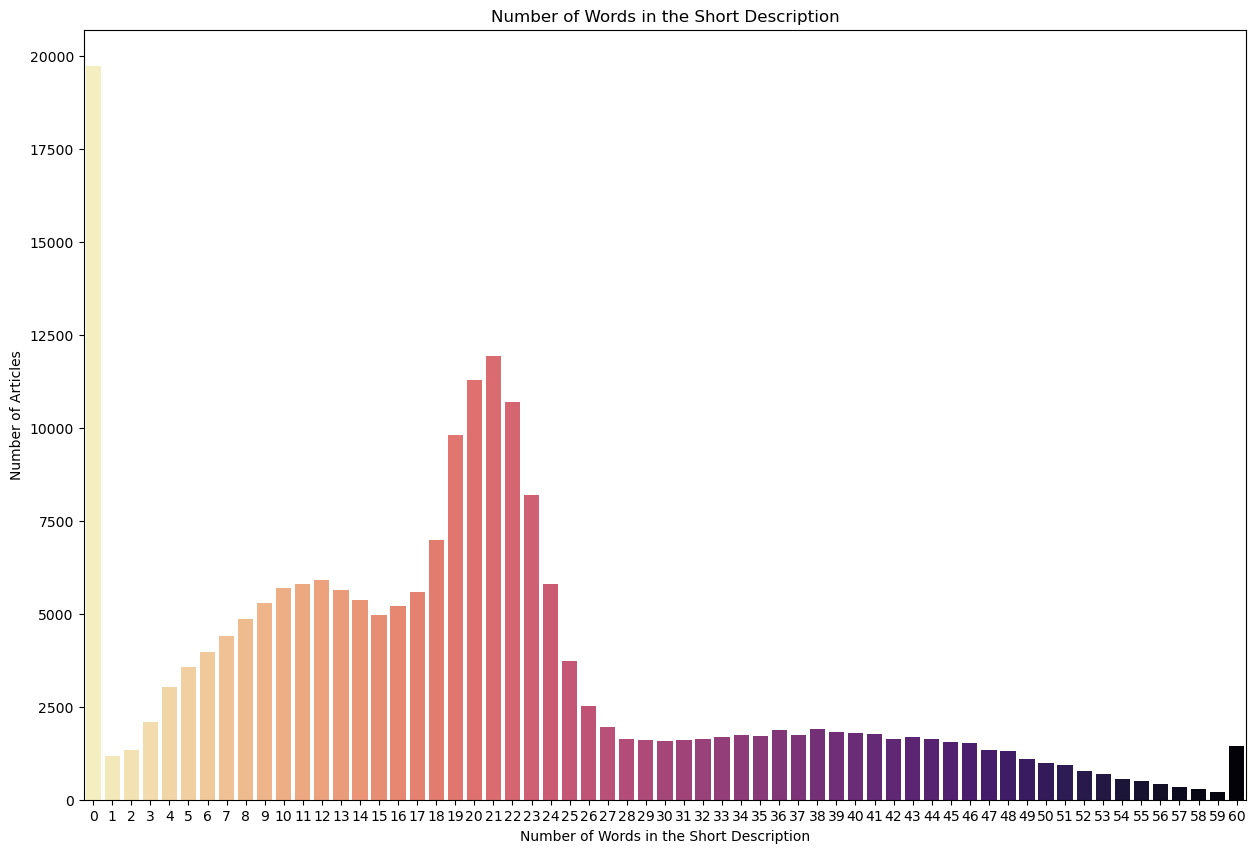

In [17]:
# Plot the Distribution of the Number of Words in the Short Description.
capped_word_count = df['word_count_description'].apply(lambda x: 60 if x >= 60 else x)

plt.figure(figsize=(15, 10))
ax = sns.countplot(x=capped_word_count, 
                   order=capped_word_count.value_counts().sort_index(ascending=True).index, 
                   palette="magma_r")
plt.title('Number of Words in the Short Description')
plt.ylabel('Number of Articles')
plt.xlabel('Number of Words in the Short Description')
plt.show()

Looking at the plot above, there are 19712 articles in this dataset that do not have a description, but rather just a headline. The number 60 is actually 60+. This has been capped for this plot only but not for the actual dataset.<br>
The distribution of the number of words in the short description interestingly has 3 peaks. The first peak is at 12 words, the largest peak is at 21 words and the smallest is at 38 words. This distribution is definitely not normal. It will be investigated to see if there is any correlation between the category and the word length of the short description.

There are 19712 articles that have no description and 6 that have no headline. To get a more complete view of the article, the headline and the short description will be merged together into a new feature called 'combined_information'.

In [18]:
# Create a new feature that concatenates 'headline' and 'short_description'.
df['combined_info'] = df['headline'].str.strip() + ' ' + df['short_description'].str.strip()

# Create an extra column to count the number of words in the combined_info feature.
df['word_count_combined'] = df['combined_info'].apply(lambda text: len(str(text).split()))

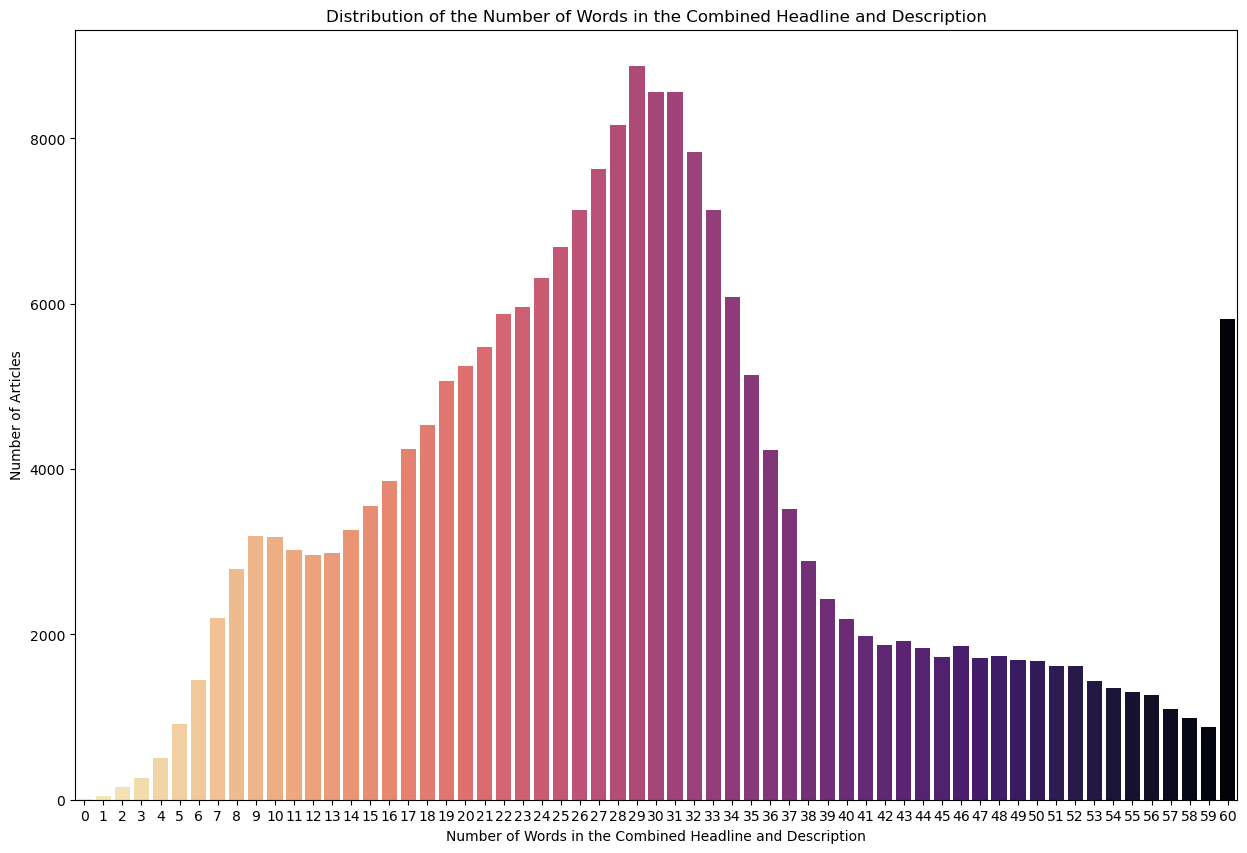

In [19]:
# Plot the Distribution of the Number of Words in the Short Description.
capped_combined_count = df['word_count_combined'].apply(lambda x: 60 if x >= 60 else x)

# Plot the Distribution of the Number of Words in the Combined Information.
plt.figure(figsize=(15, 10))
ax = sns.countplot(x=capped_combined_count, 
                   order=capped_combined_count.value_counts().sort_index(ascending=True).index, 
                   palette="magma_r")
plt.title('Distribution of the Number of Words in the Combined Headline and Description')
plt.ylabel('Number of Articles')
plt.xlabel('Number of Words in the Combined Headline and Description')
plt.show()

The peak of the combined word distribution is centred on 29 words. The number 60 is actually 60+. This has been capped for this plot only but not for the actual dataset.<br>

In [20]:
# Are there any duplicates in the combined info column?
df['combined_info'].value_counts()

Watch The Top 9 YouTube Videos Of The Week If you're looking to see the most popular YouTube videos of the week, look no further. Once again, we're bringing you the                                         46
The Funniest Tweets From Women This Week                                                                                                                                                                     33
The 20 Funniest Tweets From Women This Week The ladies of Twitter never fail to brighten our days with their brilliant ― but succinct ― wisdom. Each week, HuffPost Women                                    30
Best Parenting Tweets: What Moms And Dads Said On Twitter This Week Kids may say the darndest things, but parents tweet about them in the funniest ways. So each week, we round up the most hilarious        26
Funniest Parenting Tweets: What Moms And Dads Said On Twitter This Week Kids may say the darndest things, but parents tweet about them in the funniest ways. So each wee

There are still duplicates in the 'combined_info' column, but this number has been reduced to just 46. 46 out of 209,527 is extremely low and will not bias the results significantly. These are articles that were actually published, so they will not be removed from this project.

In [21]:
# Create new columns for the year and month of publication.
df['year'] = pd.to_datetime(df['date']).dt.year
df['month'] = pd.to_datetime(df['date']).dt.month

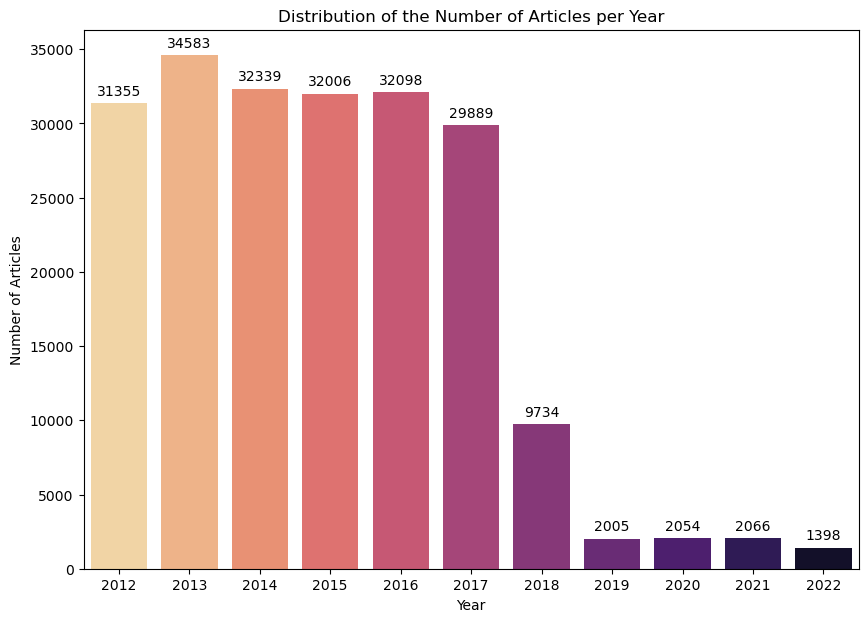

In [22]:
# Plot the Distribution of the Number of Articles per Year.
plt.figure(figsize=(10, 7))
ax = sns.countplot(x=df['year'], 
                   order=df['year'].value_counts().sort_index().index, 
                   palette="magma_r")
plt.title('Distribution of the Number of Articles per Year')
plt.ylabel('Number of Articles')
plt.xlabel('Year')

# Add the numerical quantity at the top of each bar
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2,  # get X coordinate + width / 2
            height + 550,  # set the text slightly above the bar
            '{:1.0f}'.format(height), 
            ha="center") 

plt.show()

The original dataset was made in June 2018, when a roughly even number of articles were collected from 2012 to May 2018. Since then, there have been updates to the dataset but not as many new articles were collected.

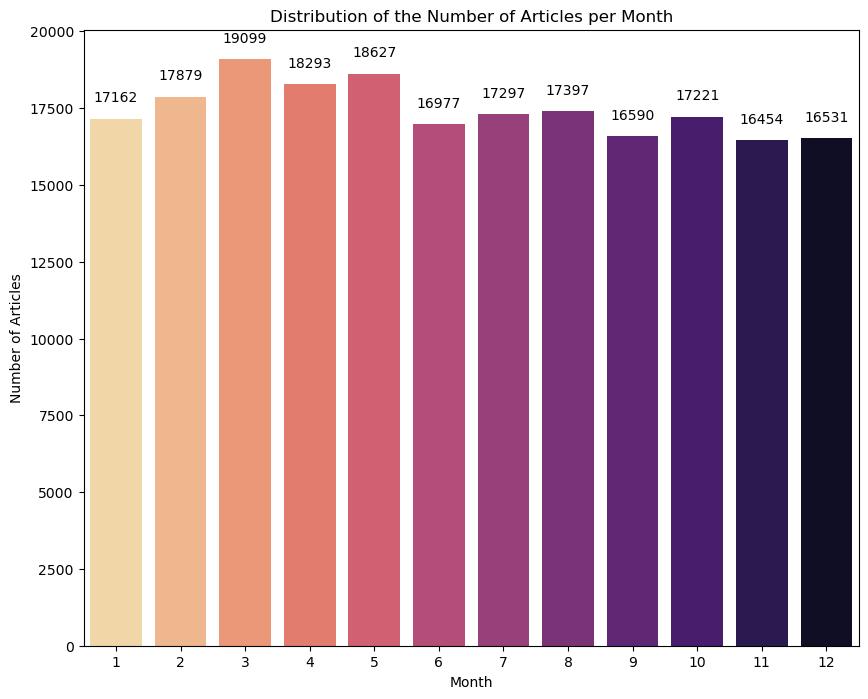

In [23]:
# Plot the Distribution of the Number of Articles per Month.
plt.figure(figsize=(10,8))
ax = sns.countplot(x=df['month'], 
                   order=df['month'].value_counts().sort_index().index, 
                   palette="magma_r")
plt.title('Distribution of the Number of Articles per Month')
plt.ylabel('Number of Articles')
plt.xlabel('Month')

# Add the numerical quantity at the top of each bar
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2,  # get X coordinate + width / 2
            height + 550,  # set the text slightly above the bar
            '{:1.0f}'.format(height), 
            ha="center") 

plt.show()

The number of articles distributed per month is relatively even. The busiest month is March with 19099 and the quietest are November and December at around 16500. These months are during the holiday period in the US and more journalists may be taking time off.

In [24]:
df.describe()

word_count_headline  word_count_description  word_count_combined  \
count        209527.000000           209527.000000        209527.000000   
mean              9.600744               19.669026            29.269770   
std               3.068507               14.152783            13.803927   
min               0.000000                0.000000             0.000000   
25%               8.000000               10.000000            20.000000   
50%              10.000000               19.000000            28.000000   
75%              12.000000               24.000000            35.000000   
max              44.000000              243.000000           245.000000   

                year          month  
count  209527.000000  209527.000000  
mean     2014.837634       6.393100  
std         2.087349       3.429701  
min      2012.000000       1.000000  
25%      2013.000000       3.000000  
50%      2015.000000       6.000000  
75%      2016.000000       9.000000  
max      2022.000000      12.000000

In [25]:
# Observe if any 'combined_info' column is empty or contains just one word.
df[df['word_count_combined'] <= 1].head(10)

link  \
63714               https://www.huffingtonpost.com/entry/manscraping_b_10573084.html   
66196                    https://www.huffingtonpost.com/entry/tire-d_b_10193554.html   
66203                https://www.huffingtonpost.com/entry/wafflewich_b_10197956.html   
72366                    https://www.huffingtonpost.com/entry/hangman_b_9506810.html   
78481                       https://www.huffingtonpost.com/entry/hugs_b_8950534.html   
81477                   https://www.huffingtonpost.com/entry/memories_b_8730174.html   
81496  https://www.huffingtonpost.com/entry/what-to-do-about-disloyal_b_8734900.html   
82119                    https://www.huffingtonpost.com/entry/podcast_b_8674486.html   
86508               https://www.huffingtonpost.com/entry/the-idealist_b_8277718.html   
90944                 https://www.huffingtonpost.com/entry/lincoln-20_b_8023742.html   

            headline  category short_description  \
63714  "ManScraping"    COMEDY                     
66196         Tire-d    COMEDY                     
66203     Wafflewich     TASTE                     
72366        Hangman    COMEDY                     
78481           Hugs    COMEDY                     
81477       Memories    COMEDY                     
81496        IGNORE.  POLITICS                     
82119        Podcast    COMEDY                     
86508          Once.    COMEDY                     
90944                 POLITICS                     

                                                                                          authors  \
63714                                                    Tom Kramer, ContributorWriter of the Wry   
66196                                          Marcia Liss, Contributor(Almost) Famous Cartoonist   
66203   Dough Mamma, ContributorPrivate chef, culinary school graduate and second-generation f...   
72366                                          Marcia Liss, Contributor(Almost) Famous Cartoonist   
78481                                          Marcia Liss, Contributor(Almost) Famous Cartoonist   
81477                                          Marcia Liss, Contributor(Almost) Famous Cartoonist   
81496                            Gabriela Rivera-Morales, ContributorBlog Editor, Huffington Post   
82119                                          Marcia Liss, Contributor(Almost) Famous Cartoonist   
86508                                          Marcia Liss, Contributor(Almost) Famous Cartoonist   
90944  Robert Moran, ContributorRobert Moran leads Brunswick Insight, and writes and speaks on...   

            date  word_count_headline  word_count_description   combined_info  \
63714 2016-06-26                    1                       0  "ManScraping"    
66196 2016-05-29                    1                       0         Tire-d    
66203 2016-05-29                    1                       0     Wafflewich    
72366 2016-03-19                    1                       0        Hangman    
78481 2016-01-10                    1                       0           Hugs    
81477 2015-12-06                    1                       0       Memories    
81496 2015-12-06                    1                       0        IGNORE.    
82119 2015-11-29                    1                       0        Podcast    
86508 2015-10-11                    1                       0          Once.    
90944 2015-08-22                    0                       0                   

       word_count_combined  year  month  
63714                    1  2016      6  
66196                    1  2016      5  
66203                    1  2016      5  
72366                    1  2016      3  
78481                    1  2016      1  
81477                    1  2015     12  
81496                    1  2015     12  
82119                    1  2015     11  
86508                    1  2015     10  
90944                    0  2015      8

In [26]:
len(df[df['word_count_combined'] <= 1])

53

Five rows were found to not have any textual information at all in the 'combined info' column. If this column is empty, no information can be conveyed into what category it belongs to. One word is also too little information to accurately classify the topic. These rows will be removed.

In [27]:
df = df[df['word_count_combined'] > 1].copy()

In [28]:
df.shape

(209474, 12)

### <span style="color: darkblue;">Reduce the Number of News Categories</span>

It was observed that many of the article categories are very similar. This will now be investigated further with the aim of merging two or more topics that are similar. 

In [29]:
# Display the number of unique categories
df['category'].nunique()

42

In [30]:
# Display all the categories
df['category'].unique()

array(['U.S. NEWS', 'COMEDY', 'PARENTING', 'WORLD NEWS', 'CULTURE & ARTS',
       'TECH', 'SPORTS', 'ENTERTAINMENT', 'POLITICS', 'WEIRD NEWS',
       'ENVIRONMENT', 'EDUCATION', 'CRIME', 'SCIENCE', 'WELLNESS',
       'BUSINESS', 'STYLE & BEAUTY', 'FOOD & DRINK', 'MEDIA',
       'QUEER VOICES', 'HOME & LIVING', 'WOMEN', 'BLACK VOICES', 'TRAVEL',
       'MONEY', 'RELIGION', 'LATINO VOICES', 'IMPACT', 'WEDDINGS',
       'COLLEGE', 'PARENTS', 'ARTS & CULTURE', 'STYLE', 'GREEN', 'TASTE',
       'HEALTHY LIVING', 'THE WORLDPOST', 'GOOD NEWS', 'WORLDPOST',
       'FIFTY', 'ARTS', 'DIVORCE'], dtype=object)

Observing the output above, there are 42 categories. There are many examples of where two or more categories are very similar and could even be considered the same. To make the classification task more realistic, some of these categories can be merged together. After careful consideration, it has been decided to merge the following categories:  

In [31]:
# Make a new feature called 'category_red' (reduced)
df['category_red'] = df['category']

In [32]:
# Merge categories by relabelling one category to another related category
df['category_red']=df['category_red'].replace({'PARENTS': 'PARENTING',
                                       'THE WORLDPOST': 'WORLD NEWS',
                                       'WORLDPOST': 'WORLD NEWS',
                                       'BUSINESS': 'BUSINESS & FINANCE',
                                       'MONEY': 'BUSINESS & FINANCE',
                                       'COLLEGE': 'EDUCATION',
                                       'STYLE': 'STYLE & BEAUTY',
                                       'GREEN': 'ENVIRONMENT',
                                       'ARTS': 'ARTS & CULTURE',
                                       'CULTURE & ARTS': 'ARTS & CULTURE',
                                       'HEALTHY LIVING': 'WELLNESS',
                                       'TASTE': 'FOOD & DRINK'})

It may have been possible to further reduce the number of articles, by combining the 'BLACK VOICES', 'QUEER VOICES' and 'LATINO VOICES' categories together and also maybe 'SCIENCE' and 'TECH' and possibly more, but I consider those to be too distinct from each other. The choices of categories I made above I believe are similar enough to be merged together.

In [33]:
# Display the number of reduced categories
df['category_red'].nunique()

31

The number of categories has now been reduced from 42 to 31. This is a reduction of 11 categories.

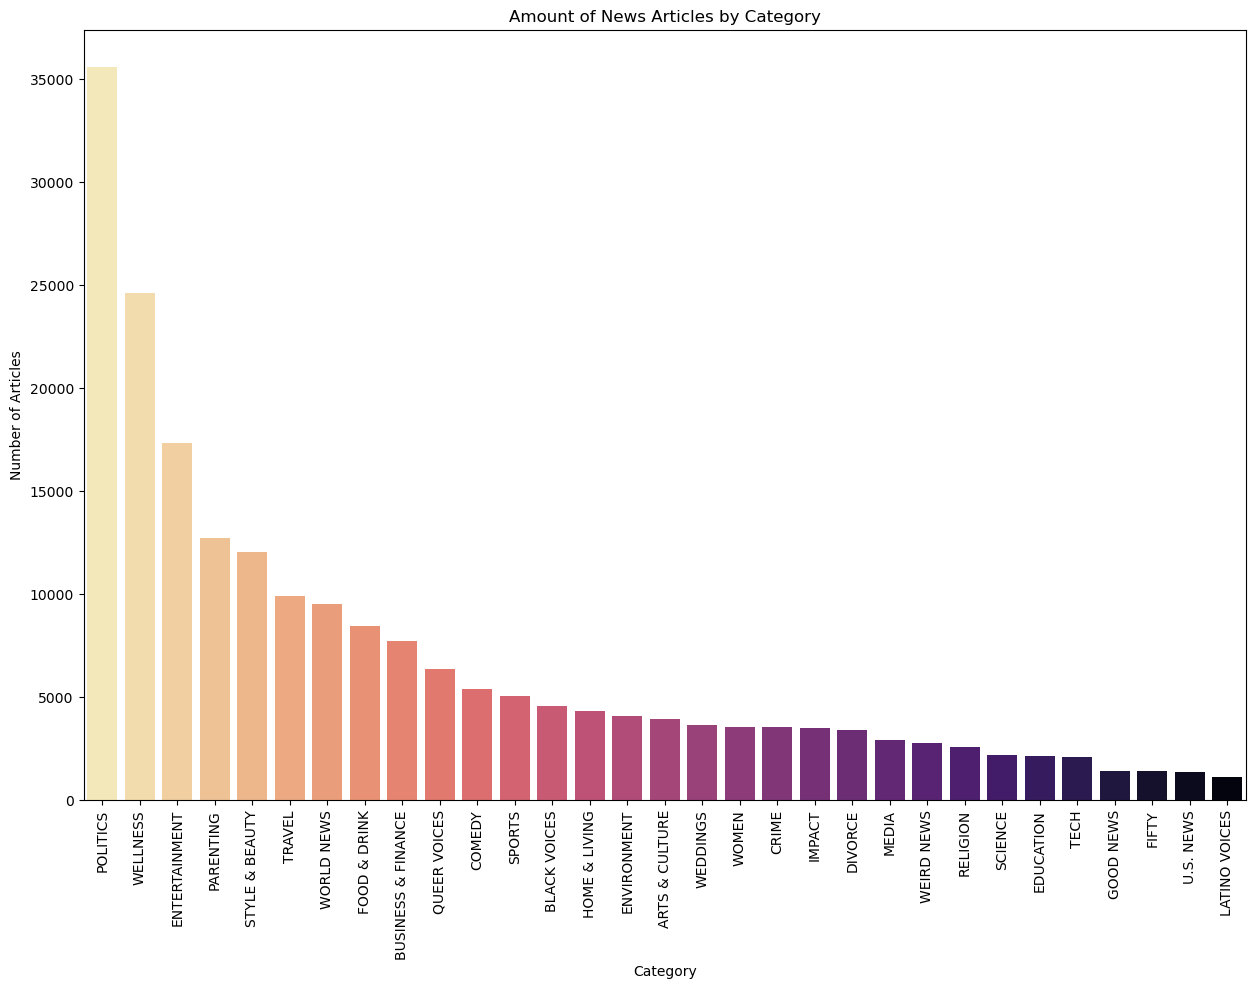

In [34]:
# Plot the distribution of news articles by new article category.
plt.figure(figsize=(15, 10))
ax = sns.countplot(x=df['category_red'], order=df['category_red'].value_counts().index, palette="magma_r")
plt.title('Amount of News Articles by Category')
plt.ylabel('Number of Articles')
plt.xlabel('Category')
plt.xticks(rotation=90)
plt.show()

There is still a large imbalance between the majority and the minority classes, which will still be a challenge, however, this will not be as bad as before.

## Feature Engineering / Data Preparation

### <span style="color: darkblue;">Text Cleaning and Preprocessing</span>

To prepare the data for natural language processing (NLP), several steps will need to be taken:<br>

1. Text Cleaning - The preprocessing step will convert the text to lowercase, strip and remove punctuations, effectively cleaning the text for further processing. 
2. Expand contractions - Contracted words are converted into two words which make more sense. Also, the apostrophes will be removed. An example of this is: "I'd" --> "I would". Many of these words will be removed by the stop word removal step.  
3. Tokenization - Partition the text into individual words and symbols. These are called tokens.
4. Stop word removal - This will remove common words that convey no meaning about the article such as "he", "she" or "on".
5. Stemming - This reduces words to their root form i.e., "shows", "showing" and "showed" will be reduced to "show".
6. Lemmatization - This also reduces words to their root form i.e., "better" and "best" will be reduced to "good". This is similar to stemming but the root words are more often real words used in English rather than just their stems.  
7. Bigrams and trigrams - Many words often connected in sequence may have a different meaning and should be joined together such as "New" followed by "York" really conveys the meaning of a city called "New York" and they should be considered one word.
8. Removal of unique words - Unique words or words that occur only one time in the entire dataset will be removed. As these words are unique, they will not be encountered in the test set if they are in the training set and so will not convey any information in identifying the topic category. This will also reduce the “noise” in the dataset and speed up processing.
  

The Natural Language Toolkit (NLTK) and Gensim libraries will be used for this project.

In [35]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [36]:
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer

import gensim

In [37]:
# Install the necessary NLTK datasets if they are not in the environment yet.
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('wordnet')

In [38]:
# Define the English language stopwords.
stop_words = set(stopwords.words('english'))

# Load the stemmer and lemmatizer
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

In [39]:
# Display the English stopwords in the NLTK library
print(stop_words)

{'d', 'been', 'doing', 'yourself', 'just', 'you', 'them', 'own', 'y', 'down', 'have', 'then', 'which', "don't", 'our', "aren't", 'what', 'below', 'couldn', "didn't", 'hers', 'her', 'ourselves', 'same', 'i', 'how', "isn't", 'was', "weren't", 'being', 'for', 'itself', 'themselves', 'both', 'until', 'these', "haven't", 'me', 'hadn', 'to', 'ain', 'doesn', "needn't", 'were', 'she', 'before', 've', 'll', 'him', "wasn't", 'has', 'the', 'than', 'they', 'from', 'further', 're', 'didn', 'theirs', 'or', 'so', 'yourselves', 'once', "couldn't", 'are', 'up', 'above', 'by', 'shouldn', 'haven', 'my', "hasn't", "doesn't", 'some', 'few', 'those', 'through', 'shan', 'into', 'now', 'be', "it's", 'don', 'ours', 'such', 'their', 'isn', 'had', 'do', 'in', 'an', 'a', 'while', 'out', 'won', 'weren', 'wouldn', 'herself', "you've", 'more', 'having', 'over', 'o', 'ma', 'aren', 'whom', 'after', 'is', 'when', "you'd", 'there', 'nor', 'will', 'again', 'other', 'myself', "should've", 'mustn', 'did', 'should', 'only',

In [40]:
len(stop_words)

179

NLTK's English stopwords library contains 179 words.

In [41]:
df.dtypes

link                              object
headline                          object
category                          object
short_description                 object
authors                           object
date                      datetime64[ns]
word_count_headline                int64
word_count_description             int64
combined_info                     object
word_count_combined                int64
year                               int64
month                              int64
category_red                      object
dtype: object

In [42]:
# Make a contractions map:
# A contraction map will convert contracted words into two words
# which make more sense. Also, the apostrophes will be removed.
# Credit: This contraction map was obtained from the following source:
# https://github.com/dipanjanS/practical-machine-learning-with-python/blob/master/bonus%20content/nlp%20proven%20approach/contractions.py

CONTRACTION_MAP = {
"ain't": "is not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he'll've": "he he will have",
"he's": "he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how is",
"I'd": "I would",
"I'd've": "I would have",
"I'll": "I will",
"I'll've": "I will have",
"I'm": "I am",
"I've": "I have",
"i'd": "i would",
"i'd've": "i would have",
"i'll": "i will",
"i'll've": "i will have",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'd've": "it would have",
"it'll": "it will",
"it'll've": "it will have",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she would",
"she'd've": "she would have",
"she'll": "she will",
"she'll've": "she will have",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as",
"that'd": "that would",
"that'd've": "that would have",
"that's": "that is",
"there'd": "there would",
"there'd've": "there would have",
"there's": "there is",
"they'd": "they would",
"they'd've": "they would have",
"they'll": "they will",
"they'll've": "they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what'll've": "what will have",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"when's": "when is",
"when've": "when have",
"where'd": "where did",
"where's": "where is",
"where've": "where have",
"who'll": "who will",
"who'll've": "who will have",
"who's": "who is",
"who've": "who have",
"why's": "why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you would",
"you'd've": "you would have",
"you'll": "you will",
"you'll've": "you will have",
"you're": "you are",
"you've": "you have"
}


In [43]:
# Credit: This function to expand contractions was obtained from the following source:
# https://www.kdnuggets.com/2018/08/practitioners-guide-processing-understanding-text-2.html
def expand_contractions(text, contraction_mapping=CONTRACTION_MAP):
    
    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())), 
                                      flags=re.IGNORECASE|re.DOTALL)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match)\
                                if contraction_mapping.get(match)\
                                else contraction_mapping.get(match.lower())                       
        expanded_contraction = first_char+expanded_contraction[1:]
        return expanded_contraction
        
    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text

In [44]:
# Credit: The processing text function shown below is based on code found at the following source:
# Reference: https://medium.com/analytics-vidhya/nlp-tutorial-for-text-classification-in-python-8f19cd17b49e
# The preprocessing step will convert the text to lowercase, strip and remove punctuations
# effectively cleaning the text for further processing.

def preprocess_text(text):
    # Convert the text to lowercase
    text = text.lower()
    # Call the expand contractions function
    # It was found that this led to a minor decrease in model performance so it has been commented out.
    #text = expand_contractions(text)
    # Remove any leading or trailing whitespace.
    text = text.strip()
    # Remove any HTML tags from the text
    text = re.compile('<.*?>').sub('', text)
    # Replace any punctuation with a space
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text)
    # Remove any square-bracketed numbers (like [10], [23], etc.)
    text = re.sub(r'\[[0-9]*\]', ' ', text)
    # Remove any non-alphanumeric characters (excluding spaces)
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
    # Replace multiple spaces with a single space
    text = re.sub(r'\s+', ' ', text)
    return text

In [45]:
# This is a modification from the preprocess_text function for preparation of DistilBERT.
# The difference is that the replacing the punctuation with a space step has been removed. 
# DistilBERT considers punctuation in the sentence's context, so the punctuation marks remain.

# The time taken to run DistilBERT would have been far too long. Its code has been removed,
# but I have kept this function for future work.

def preprocess_text_bert(text):
    # Convert the text to lowercase
    text = text.lower()
    # Call the expand contractions function
    text = expand_contractions(text)
    # Remove any leading or trailing whitespace.
    text = text.strip()
    # Remove any HTML tags from the text
    text = re.compile('<.*?>').sub('', text)
    # Remove any square-bracketed numbers (like [10], [23], etc.)
    text = re.sub(r'\[[0-9]*\]', ' ', text)
    # Remove any non-alphanumeric characters (excluding spaces)
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
    # Replace multiple spaces with a single space
    text = re.sub(r'\s+', ' ', text)
    return text

In [46]:
# Create a wordcloud for the desired column
def plot_word_cloud(lemmatized_words, col_name):
    # Combine all the words into one list instead of a list of lists
    word_list = [word for sublist in lemmatized_words for word in sublist]

    # Combine all the words into one large text
    text = ' '.join(word_list)

    # Create the word cloud object
    wc = WordCloud(width=800, height=800, colormap='Spectral', background_color='black', 
                   stopwords=set('english'), max_words=200, contour_color='black')

    # Generate the word cloud
    wc.generate(text)

    # Display the word cloud
    plt.figure(figsize=(8, 8))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for {col_name}')
    plt.show()

In [47]:
def process_column(df, column_name):
    # 1. Text Cleaning
    clean_text = df[column_name].apply(lambda x: preprocess_text(x))
    
    # 2. Tokenization - Tokenize the articles into words and punctuation.
    tokenized_text = clean_text.apply(word_tokenize)
    
    # 3. Removal of Stop Words
    stop_words = set(stopwords.words('english'))
    stop_words_removed = tokenized_text.apply(lambda x: [word for word in x if word not in stop_words])
    
    # Bigrams and trigams reduced the classification accuracy so it has been disabled.
    """
    # 4. Add Bi-grams
    # Convert the stop words removed tokenized data into a list of lists format for bigram model training
    bigrams_input = stop_words_removed.tolist()   
    # Create a bigram phraser. The bigram phrase must appear at least 5 times to be considered.
    bigram = Phrases(bigrams_input, min_count=200, threshold=200)
    bigram_phraser = Phraser(bigram)   
    # Apply the bigram phraser on the tokenized data
    bigram_output = [bigram_phraser[doc] for doc in bigrams_input]
       
    unique_bigrams = set()
    for doc in bigram_output[:2000]:
        for token in doc:
            if "_" in token:  # bigrams are represented with underscores
                unique_bigrams.add(token)
    
    print(f'Number of bigrams: {len(unique_bigrams)}')
    print(unique_bigrams)
    
    # Add Tri-grams - This is effectively the same process as bigrams, where a third word may be added to a bigram word
    # if the sequence occurs sufficiently
    trigram = Phrases(bigram_output, min_count=5, threshold=30)
    trigram_phraser = Phraser(trigram)
    trigram_output = [trigram_phraser[bigram_phraser[doc]] for doc in bigrams_input] 
    """
    # Stemming
    stemmer = PorterStemmer()
    stemmed_words = stop_words_removed.apply(lambda x: [stemmer.stem(word) for word in x])
    
    # Stemming was more accurate than lemmatization for the best model performance.
    # 4. Perform lemmatization on all words.
    #lemmatizer = WordNetLemmatizer()
    #lemmatized_words = list(map(lambda doc: [lemmatizer.lemmatize(word) for word in doc], stop_words_removed))
    
    # Convert lemmatized/stemmed words back to string format and add to the dataframe
    processed_column_name = 'processed_' + column_name
    df[processed_column_name] = [' '.join(words) for words in stemmed_words]

    return df, stemmed_words

In [48]:
# Select the Headline column to process
df, lemmatized_words = process_column(df, 'headline')

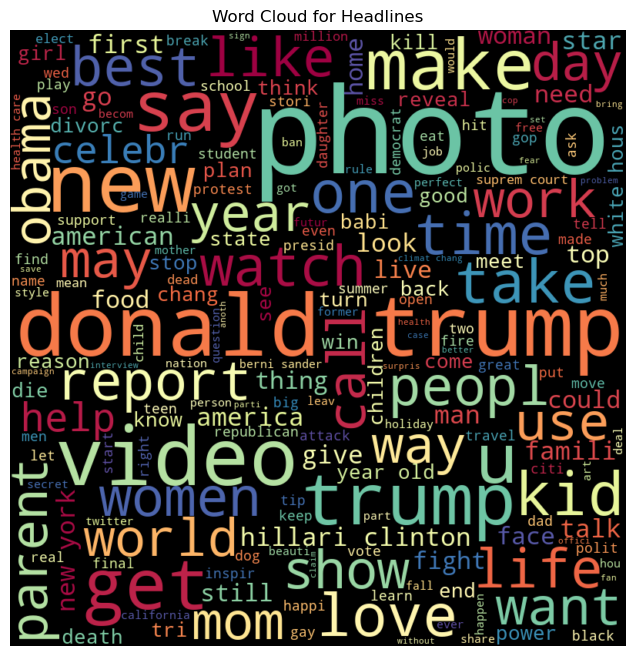

In [49]:
# Plot a word cloud for the Headlines
plot_word_cloud(lemmatized_words, 'Headlines')

In [50]:
# Process the 'short description' column and plot the word cloud
df, lemmatized_words = process_column(df, 'short_description')

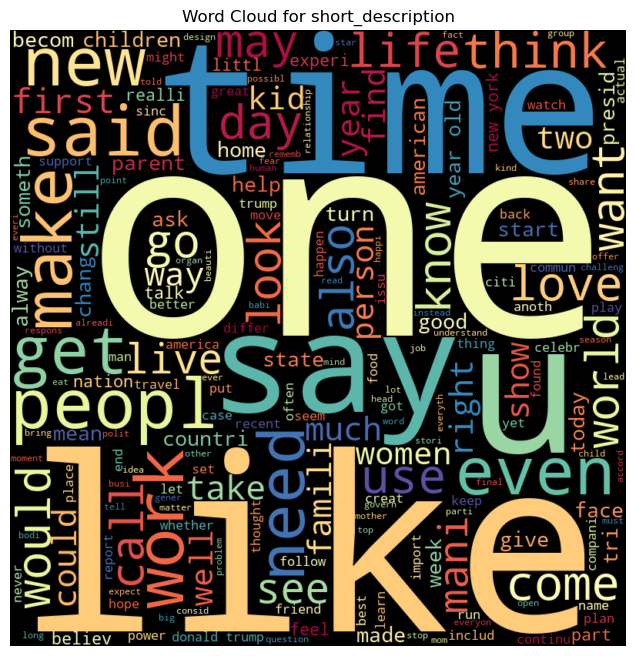

In [51]:
plot_word_cloud(lemmatized_words, 'short_description')

In [52]:
# Process the 'combined info' column and plot the word cloud
df, lemmatized_words = process_column(df, 'combined_info')

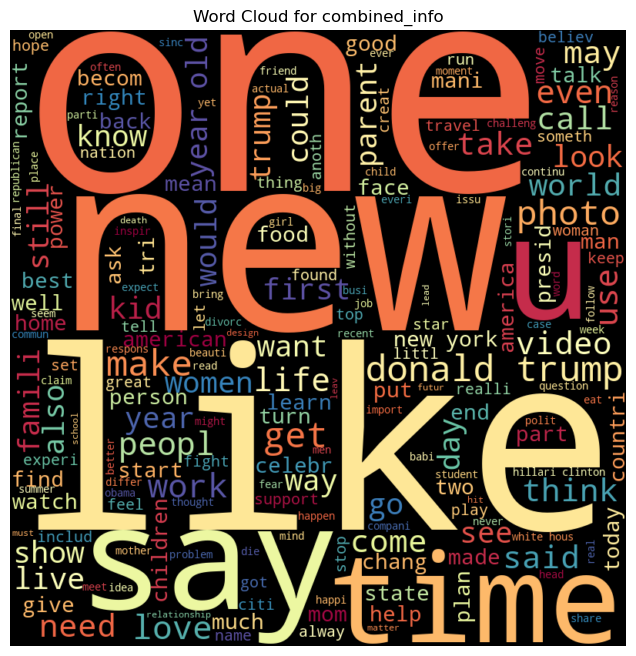

In [53]:
plot_word_cloud(lemmatized_words, 'combined_info')

In [54]:
df['combined_info'][100]

'U.S.: Russia To Buy Rockets, Artillery Shells From North Korea The finding comes after the Biden administration confirmed that the Russian military in August took delivery of Iranian-manufactured drones for use in Ukraine.'

In [55]:
df['processed_combined_info'][100]

'u russia buy rocket artilleri shell north korea find come biden administr confirm russian militari august took deliveri iranian manufactur drone use ukrain'

**View the header after the creation of the processed column**

In [56]:
df.head(2)

link  \
0                                                      https://www.huffpost.com/entry/covid-boosters-uptake-us_n_632d719ee4b087fae6feaac9   
1  https://www.huffpost.com/entry/american-airlines-passenger-banned-flight-attendant-punch-justice-department_n_632e25d3e4b0e247890329fe   

                                                                                    headline  \
0               Over 4 Million Americans Roll Up Sleeves For Omicron-Targeted COVID Boosters   
1  American Airlines Flyer Charged, Banned For Life After Punching Flight Attendant On Video   

    category  \
0  U.S. NEWS   
1  U.S. NEWS   

                                                                                                                                                 short_description  \
0       Health experts said it is too early to predict whether demand would match up with the 171 million doses of the new boosters the U.S. ordered for the fall.   
1  He was subdued by passengers and crew when he fled to the back of the aircraft after the confrontation, according to the U.S. attorney's office in Los Angeles.   

                authors       date  word_count_headline  \
0  Carla K. Johnson, AP 2022-09-23                   11   
1        Mary Papenfuss 2022-09-23                   13   

   word_count_description  \
0                      29   
1                      28   

                                                                                                                                                                                                                                               combined_info  \
0                    Over 4 Million Americans Roll Up Sleeves For Omicron-Targeted COVID Boosters Health experts said it is too early to predict whether demand would match up with the 171 million doses of the new boosters the U.S. ordered for the fall.   
1  American Airlines Flyer Charged, Banned For Life After Punching Flight Attendant On Video He was subdued by passengers and crew when he fled to the back of the aircraft after the confrontation, according to the U.S. attorney's office in Los Angeles.   

   word_count_combined  year  month category_red  \
0                   40  2022      9    U.S. NEWS   
1                   41  2022      9    U.S. NEWS   

                                               processed_headline  \
0      4 million american roll sleev omicron target covid booster   
1  american airlin flyer charg ban life punch flight attend video   

                                                                             processed_short_description  \
0  health expert said earli predict whether demand would match 171 million dose new booster u order fall   
1                        subdu passeng crew fled back aircraft confront accord u attorney offic lo angel   

                                                                                                                                            processed_combined_info  
0  4 million american roll sleev omicron target covid booster health expert said earli predict whether demand would match 171 million dose new booster u order fall  
1                    american airlin flyer charg ban life punch flight attend video subdu passeng crew fled back aircraft confront accord u attorney offic lo angel

**Removal of the unique words from "processed_combined_info"**  
Unique words that appear only once in the entire corpus will not be very useful for classification of categories. These words will be removed.

In [57]:
def remove_unique_words(df, column):
    # Extract all the words from all the speeches in the 'Processed_Text' column
    split_words = df[column].str.split().tolist()
    # Flatten the list of lists and count the frequency of each word
    word_frequency = Counter(word for row in split_words for word in row)
    print(f'word count: {len(word_frequency)}')
    # Obtain a set of all the words appearing only once (unique words)
    unique_words = set()
    for word, count in word_frequency.items():
        if count == 1:
            unique_words.add(word)
    print(f'num unique words: {len(unique_words)}')   
    
    # Remove the unique words from all articles of the specified column
    col_without_unique = []
    for row in split_words:
        row_without_unique = []
        # Search through all words in each row and only keep the words that are not in the unique word set
        for word in row:
            if word not in unique_words:
                row_without_unique.append(word)
        # Join the word lists into a string and append to the column series.
        col_without_unique.append(" ".join(row_without_unique))
        
    # Apply the column series to the specified column
    df[column] = col_without_unique
    return df


In [58]:
df = remove_unique_words(df, 'processed_combined_info')

word count: 62896
num unique words: 25711


There are 62,896 different words in the entire corpus. 25,711 words appear only once. They were removed from the corpus.

**Split the data into training and test sets**

In [59]:
# 1. Split the data into training and test sets.
X_train, X_test, y_train, y_test = train_test_split(df["processed_combined_info"],df["category_red"],test_size=0.2,
                                    stratify=df["category_red"], random_state=12, shuffle=True)

## For Traditional Models

### Text Vectorization

Machine learning models require numerical input rather than textual, so text needs to be converted into vectors. Converting text into numerical data is called 'vectorization' or 'embedding'.<br>

**Bag of words** is a basic method that converts text to vectors. Each word in the corpus is given an index and the word's frequency is associated with it. There are no more complex structures for this method.<br>

It was observed that bag of words did not perform as well as tf-idf for the baseline. It will be evaluated again on the more complex models.

**Term Frequency-Inverse Document Frequencies (Tf-Idf)**  
is a more advanced method. Instead of just counting the number of words, tf-Idf  also adjusts word values based on their occurrence frequency in all the headline rows, reducing the weight to the more commonly occurring terms.

In [60]:
# 2. Vectorization - Method 1 - This limits the number of features to the top max_features most frequent terms
vectorizer = TfidfVectorizer(max_features=50000)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)


In [61]:
# The model had the highest accuracy using the previous method of Tf-idf vectorization
"""
# 2. Vectorization - Method 2
# Exclude the words that appear in more than 95% of the combined_info entries and
# Include only words that appear in 2 or more documents.

# Set up the TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')

# Fit and transform the training data
X_train_vec = tfidf_vectorizer.fit_transform(X_train)

# Transform the test data
X_test_vec = tfidf_vectorizer.transform(X_test)
"""

"\n# 2. Vectorization - Method 2\n# Exclude the words that appear in more than 95% of the combined_info entries and\n# Include only words that appear in 2 or more documents.\n\n# Set up the TfidfVectorizer\ntfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')\n\n# Fit and transform the training data\nX_train_vec = tfidf_vectorizer.fit_transform(X_train)\n\n# Transform the test data\nX_test_vec = tfidf_vectorizer.transform(X_test)\n"

This method was observed to work best for all the text vectorization methods tested, unless a high value of max_features was used in Method 1.

**Word2vec**  
This is a more advanced neural network-based algorithm that learns word associations from a large corpus of text. Word2vec creates vectors of the words that are distributed numerical representations of word features – these word features could comprise of words that represent the context of the individual words present in our vocabulary. Word embeddings eventually help in establishing the association of a word with another similar meaning word through the created vectors. Credit: Analytics Vidhya.


It was observed that Word2vec did not perform as well as tf-idf for the baseline models. It will be evaluated again on the more complex models.

## Machine Learning  

Two models have been used as a baseline for testing the dataset. A Multinomial Naive-Bayes model and a Logistic Regression model. These are two basic models. The purpose of this section for the mid-semester report is to demonstrate that a baseline model can be used to produce an output on the chosen dataset. The models have been left with their default hyperparameter settings and were not tuned. For the final report, more advanced models will be evaluated and tuned to obtain maximum performance. 

In the baseline, various text processing and vectorization steps were configured to determine which steps work best for this dataset. Please refer to the midsemester report for the evaluation of the preprocessing steps. The configuration shown here is for the best combination of all the preprocessing steps that were evaluated.

Note that the best result was achieved on the logistic regression model.

#### Multinomial Naive-Bayes Model

In [62]:
# 3. Train the Naive-Bayes model
nb1 = MultinomialNB()
nb1.fit(X_train_vec, y_train)

MultinomialNB()

**Display the model's parameters**

In [63]:
# Display the model's parameters.
nb1.get_params()

{'alpha': 1.0, 'class_prior': None, 'fit_prior': True, 'force_alpha': 'warn'}

**Evaluate the model**

In [64]:
# 4. Evaluate the model
y_pred_nb1 = nb1.predict(X_test_vec)

In [65]:
# Display the model's classification accuracy
accuracy_nb1 = accuracy_score(y_test, y_pred_nb1)
print(f"Accuracy: {accuracy_nb1 * 100:.2f}%")

# Classification Report
sorted_labels = sorted(y_test.unique())
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred_nb1, labels=sorted_labels))

Accuracy: 50.67%

Classification Report:



C:\Users\alang\anaconda3\envs\python310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                    precision    recall  f1-score   support

    ARTS & CULTURE       0.92      0.04      0.08       784
      BLACK VOICES       0.71      0.01      0.01       917
BUSINESS & FINANCE       0.72      0.13      0.22      1549
            COMEDY       0.81      0.03      0.05      1077
             CRIME       0.72      0.06      0.11       712
           DIVORCE       0.98      0.07      0.13       685
         EDUCATION       0.00      0.00      0.00       431
     ENTERTAINMENT       0.50      0.77      0.61      3472
       ENVIRONMENT       0.74      0.05      0.09       813
             FIFTY       0.00      0.00      0.00       279
      FOOD & DRINK       0.81      0.61      0.69      1687
         GOOD NEWS       0.00      0.00      0.00       279
     HOME & LIVING       0.95      0.19      0.31       864
            IMPACT       1.00      0.00      0.00       697
     LATINO VOICES       0.00      0.00      0.00       226
             MEDIA       1.00      0.00

C:\Users\alang\anaconda3\envs\python310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\alang\anaconda3\envs\python310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


For the Naive-Bayes model, the minority classes were often never or seldom predicted. Class imbalance is clearly an issue with this model.

**Confusion Matrix**

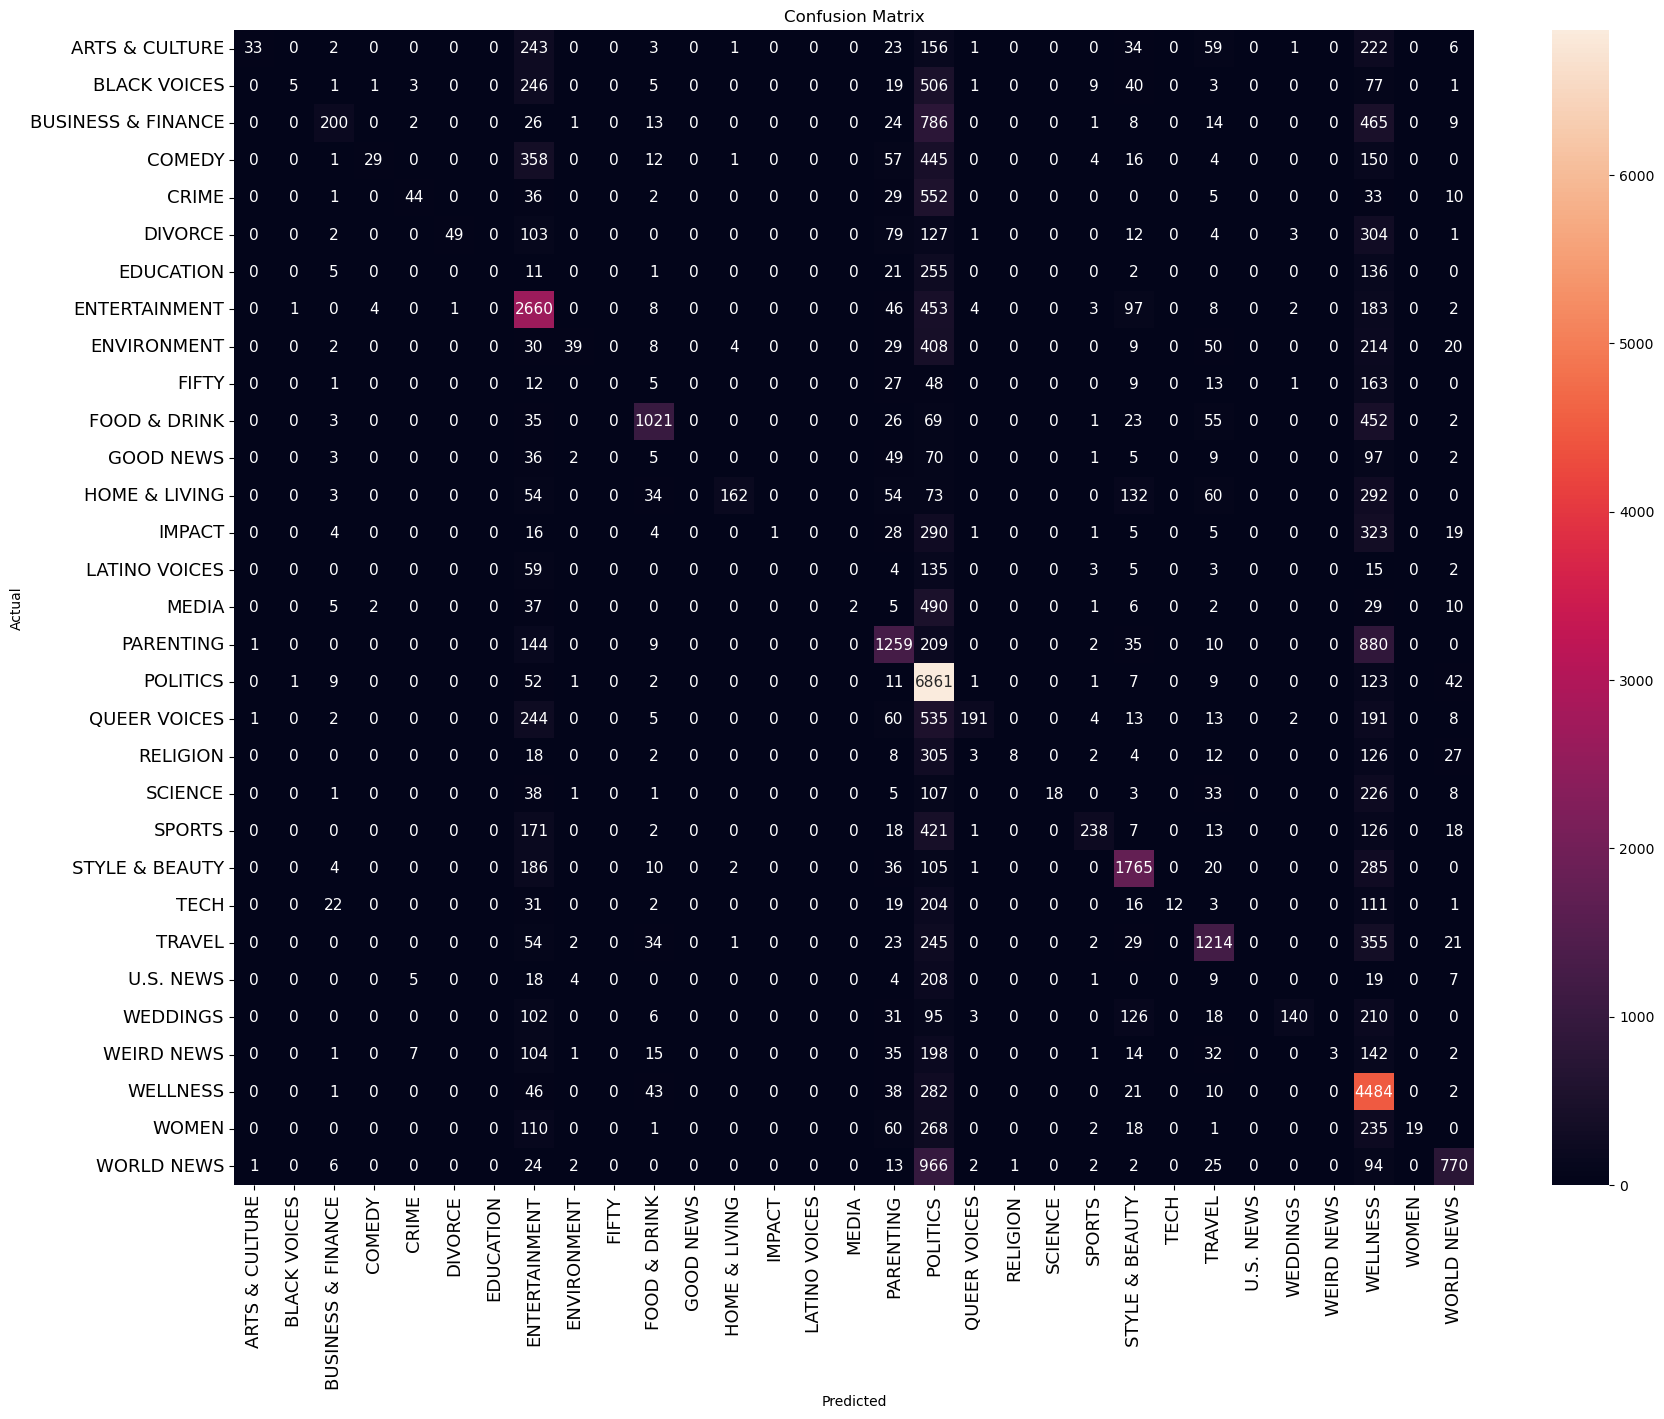

In [66]:
# Generate the confusion matrix
conf_matrix_nb1 = confusion_matrix(y_test, y_pred_nb1, labels=sorted_labels)

# Plot the confusion matrix
plt.figure(figsize=(20, 15))
sns.heatmap(conf_matrix_nb1, annot=True, fmt="d", annot_kws={"size": 11},
            xticklabels=sorted_labels, yticklabels=sorted_labels, cmap="rocket")

# Set the plot configurations
plt.xticks(fontsize=13)  
plt.yticks(fontsize=13)  
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

**Evaluation**  
In the base line for the mid semester report, the Naive Bayes had an overall accuracy of 43.64% This has gone up to 50.67% for the same model configuration. Merging 11 similar categories has proven to be extremely beneficial to the overall accuracy of classifying these news articles.  

There are still several minority classes that are rarely or never predicted such as 'Fifty' and 'Media'.

#### Logistic Regression Model

In [67]:
# Train the Logistic Regression model
lr1 = LogisticRegression(max_iter=600, random_state=12)

**Display the model's parameters**

In [68]:
# Display the model's parameters.
params = lr1.get_params()
params

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 600,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 12,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

**Perform a grid search and tune the hyperparameters**  
A grid search was performed for the Logistic Regression Model. It did not result in improved performance, so the code has been commented out.

**Parameters setup:**<br>
A small grid search was set up. From experience, liblinear, and newton-cg solvers take a much longer time to process.

In [69]:
param_grid = [
    {
        'penalty': ['l1', 'l2', 'elasticnet', 'none'],  # Regularization techniques
        'C': [0.001, 0.01, 0.1, 0.8, 0.9, 1, 1.1, 1.2, 10, 100],  # Inverse of regularization strength
        'solver': ['lbfgs', 'sag', 'saga'],  # Solver algorithm
        'max_iter': [100, 600],  # Maximum number of iterations used for the solvers to converge
        'class_weight': [None, 'balanced'],  # Set the class weights
        'random_state': [12]  # Set a seed for consistent results
    }
]

In [70]:
# A grid search was run for to tune the hyper parameters for the Logistic Regression Model
# It did not result in improved performance over the default model.
"""
# Define the grid search

# set up cross validation to split into 5 folds.
strat_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=12)

# Load the model and all parameters into the grid search.
gsc1 = GridSearchCV(estimator=lr1, param_grid=param_grid, cv=strat_kfold,
                    scoring='accuracy', n_jobs=-1, verbose=2)
"""

"\n# Define the grid search\n\n# set up cross validation to split into 5 folds.\nstrat_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=12)\n\n# Load the model and all parameters into the grid search.\ngsc1 = GridSearchCV(estimator=lr1, param_grid=param_grid, cv=strat_kfold,\n                    scoring='accuracy', n_jobs=-1, verbose=2)\n"

In [71]:
# Grid search has been disabled
"""
# get the start time
st = time.time()

# Test and fit the grid search options to the training data.
gsc1.fit(X_train_vec, y_train)

# get the end time
et = time.time()

# get the execution time
elapsed_time = et - st
print(str(round(elapsed_time,2)) + " seconds")
"""

'\n# get the start time\nst = time.time()\n\n# Test and fit the grid search options to the training data.\ngsc1.fit(X_train_vec, y_train)\n\n# get the end time\net = time.time()\n\n# get the execution time\nelapsed_time = et - st\nprint(str(round(elapsed_time,2)) + " seconds")\n'

**Display the best hyperparameter settings**

In [72]:
# Grid search has been disabled
"""
print("Best Hyper Parameters:", gsc1.best_params_)
"""

'\nprint("Best Hyper Parameters:", gsc1.best_params_)\n'

**Calculate the metrics**

In [73]:
# Grid search has been disabled
"""
# Summarize the results
print("Best: %f using %s" % (gsc1.best_score_, gsc1.best_params_))
means = gsc1.cv_results_['mean_test_score']
stds = gsc1.cv_results_['std_test_score']
params = gsc1.cv_results_['params']
"""

'\n# Summarize the results\nprint("Best: %f using %s" % (gsc1.best_score_, gsc1.best_params_))\nmeans = gsc1.cv_results_[\'mean_test_score\']\nstds = gsc1.cv_results_[\'std_test_score\']\nparams = gsc1.cv_results_[\'params\']\n'

**Predict the classifications on the test set**

In [74]:
# Grid search has been disabled
"""
lr1 = gsc1.best_estimator_
"""

'\nlr1 = gsc1.best_estimator_\n'

**Fit the Model**

In [75]:
lr1.fit(X_train_vec, y_train)

LogisticRegression(max_iter=600, random_state=12)

**Save the Model**

In [76]:
joblib.dump(lr1, 'models/lr1.pkl')

['models/lr1.pkl']

**Display the best model parameters**

In [77]:
lr1.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 600,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 12,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

**Predict the classifications on the test set**

In [78]:
# Evaluate the model
y_pred_lr1 = lr1.predict(X_test_vec)

In [79]:
# Verify the predictions and test set label counts.
from collections import Counter

label_counts = Counter(y_pred_lr1)
print(label_counts)

Counter({'POLITICS': 8585, 'WELLNESS': 6448, 'ENTERTAINMENT': 4480, 'PARENTING': 2826, 'STYLE & BEAUTY': 2529, 'TRAVEL': 2078, 'WORLD NEWS': 1879, 'FOOD & DRINK': 1761, 'BUSINESS & FINANCE': 1435, 'QUEER VOICES': 993, 'SPORTS': 982, 'HOME & LIVING': 770, 'COMEDY': 686, 'ENVIRONMENT': 673, 'CRIME': 657, 'WEDDINGS': 654, 'ARTS & CULTURE': 577, 'BLACK VOICES': 560, 'DIVORCE': 528, 'WOMEN': 408, 'RELIGION': 359, 'IMPACT': 348, 'MEDIA': 339, 'EDUCATION': 310, 'TECH': 278, 'WEIRD NEWS': 260, 'SCIENCE': 254, 'FIFTY': 84, 'LATINO VOICES': 73, 'GOOD NEWS': 62, 'U.S. NEWS': 19})


In [80]:
label_counts2 = Counter(y_test)
print(label_counts2)

Counter({'POLITICS': 7120, 'WELLNESS': 4927, 'ENTERTAINMENT': 3472, 'PARENTING': 2549, 'STYLE & BEAUTY': 2414, 'TRAVEL': 1980, 'WORLD NEWS': 1908, 'FOOD & DRINK': 1687, 'BUSINESS & FINANCE': 1549, 'QUEER VOICES': 1269, 'COMEDY': 1077, 'SPORTS': 1015, 'BLACK VOICES': 917, 'HOME & LIVING': 864, 'ENVIRONMENT': 813, 'ARTS & CULTURE': 784, 'WEDDINGS': 731, 'WOMEN': 714, 'CRIME': 712, 'IMPACT': 697, 'DIVORCE': 685, 'MEDIA': 589, 'WEIRD NEWS': 555, 'RELIGION': 515, 'SCIENCE': 441, 'EDUCATION': 431, 'TECH': 421, 'FIFTY': 279, 'GOOD NEWS': 279, 'U.S. NEWS': 275, 'LATINO VOICES': 226})


**Display accuracy, precision and recall on the test set**

In [81]:
print("Accuracy:",round(metrics.accuracy_score(y_test, y_pred_lr1),5))
print("Precision:",round(metrics.precision_score(y_test, y_pred_lr1, average = 'weighted'),5))
print("Recall:",round(metrics.recall_score(y_test, y_pred_lr1, average = 'weighted'),5))
print("F1-score:",round(metrics.f1_score(y_test, y_pred_lr1, average = 'weighted'),5))

Accuracy: 0.66757
Precision: 0.66074
Recall: 0.66757
F1-score: 0.6516


In [82]:
# Display the model's classification accuracy
accuracy = accuracy_score(y_test, y_pred_lr1)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Displaying the classification report
sorted_labels = sorted(y_test.unique())
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred_lr1, labels=sorted_labels))

Accuracy: 66.76%

Classification Report:

                    precision    recall  f1-score   support

    ARTS & CULTURE       0.61      0.45      0.52       784
      BLACK VOICES       0.55      0.34      0.42       917
BUSINESS & FINANCE       0.58      0.54      0.56      1549
            COMEDY       0.61      0.39      0.48      1077
             CRIME       0.58      0.53      0.55       712
           DIVORCE       0.84      0.65      0.73       685
         EDUCATION       0.51      0.37      0.43       431
     ENTERTAINMENT       0.59      0.76      0.67      3472
       ENVIRONMENT       0.53      0.44      0.48       813
             FIFTY       0.46      0.14      0.21       279
      FOOD & DRINK       0.75      0.78      0.77      1687
         GOOD NEWS       0.45      0.10      0.16       279
     HOME & LIVING       0.78      0.70      0.74       864
            IMPACT       0.51      0.25      0.34       697
     LATINO VOICES       0.82      0.27      0.40       2

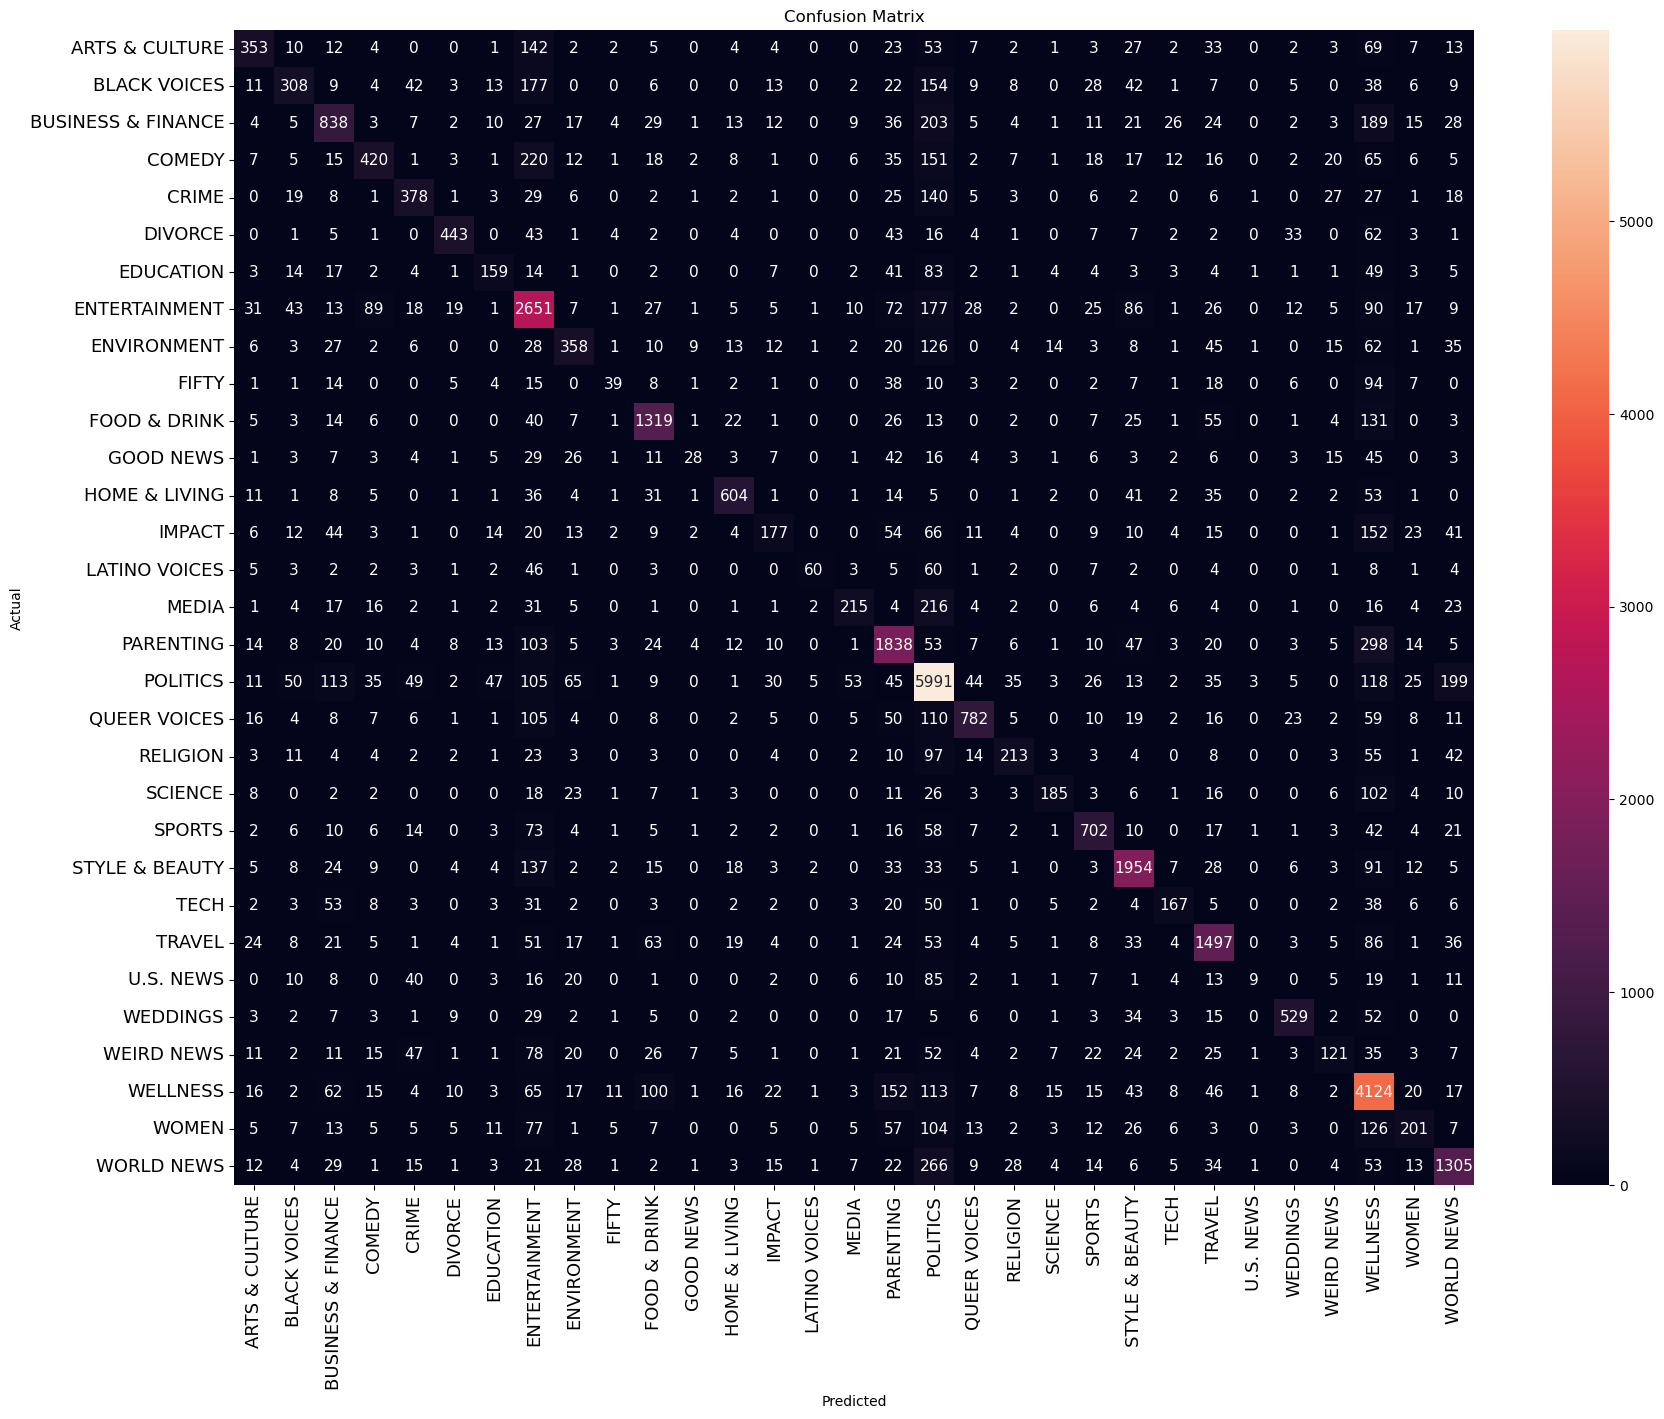

In [83]:
# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_lr1, labels=sorted_labels)

# Plot the confusion matrix
plt.figure(figsize=(20, 15))
sns.heatmap(conf_matrix, annot=True, fmt="d", annot_kws={"size": 11},
            xticklabels=sorted_labels, yticklabels=sorted_labels, cmap="rocket")

# Set the plot configurations
plt.xticks(fontsize=13)
plt.yticks(fontsize=13) 
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

The best model is the logistic regression model which not only had a much higher accuracy than the Naive-Bayes, but it also made predictions for every label. Further work will continue on this project with more advanced classifiers.

Merging similar categories has also proven to be extremely beneficial to the Logistic Regression model, with overall accuracy improving from 60.51% to 66.45%. The precision, recall and F1-score has also seen significant improvements on most individual categories and overall.

## Preparation for RNN

The baseline has demonstrated that basic classifiers can be used successfully on this dataset. The rest of this project will set out to improve on the baseline score by employing more advanced deep learning algorithms.

#### Tokenization and Sequence Padding

Before using deep learning algorithms, the textual data must be further preprocessed.

In [95]:
# Import the required libraries for deep learning
import tensorflow
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, GRU, Dense
from tensorflow.keras.callbacks import EarlyStopping, LambdaCallback
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

In [199]:
seed = 12
np.random.seed(seed)
tensorflow.random.set_seed(seed)

**Label Encoding**  

Target variable categories are encoded as integers. This is required for modelling.

In [200]:
# Label Encoding
# Target variable categories are encoded as integers. This is required for modelling
label_encoder = LabelEncoder()

# Fit the label encoder on the whole data
label_encoder.fit(df["category_red"])

LabelEncoder()

In [201]:
# Transform the train and testing labels to numbers based on the fitted encoder
y_train_encoded = label_encoder.transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

In [202]:
# Apply One-Hot Encoding
# This is encoded into a binary matrix which is required for multi-class classification
# 'y_train_encoded' and 'y_test_encoded' are integer-encoded. 
y_train_one_hot = to_categorical(y_train_encoded)
y_test_one_hot = to_categorical(y_test_encoded)

**Tokenization**  

Machine learning models require numerical input rather than textual, so text needs to be converted into vectors. Converting text into numerical data is called 'vectorization' or 'embedding'. The text data is encoded as integers, which are all mapped to a unique word. The most frequently occurring words are ranked earlier in the list.

In [203]:
# Prepare the tokenizer

## num_words restricted to top 15,000.
#max_num_words = 15000
## Unkown words in the test set will be skipped
#tokenizer = Tokenizer(num_words=max_num_words, oov_token="<UNK>")

# All words in the train set are considered
tokenizer = Tokenizer(oov_token="<UNK>")  
tokenizer.fit_on_texts(X_train)

vocab_size = len(tokenizer.word_index) + 1  # Use the entire word index, add 1 because of reserved 0 index
max_num_words = vocab_size  # This parameter was tested during various evaluations

In [204]:
# Display the number of unique words in the train dataset 
# after previous removal of one time only words.
print(max_num_words)

36338


In [205]:
# Convert text data to integer sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

**Pad Sequences**  

The text entries will have various lengths. Padding will fill the shorter entries with zeros up to the maximum length so that all sequences are of equal length. The same input dimensions are required for the ML process.

In [206]:
# Pad sequences to the same length

# Set a maximum length based on a percentile that covers most of the data lengths:
#max_length = int(np.percentile([len(seq) for seq in X_train_seq], 99))  # the 90th percentile worked best
# Set to the maximum length
max_length = max(len(seq) for seq in X_train_seq)

# Pad the train and test sets with the max length
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length, padding='post')

#### GRU - Gated Recurrent Unit  
A GRU is a type of recurrent neural network (RNN) with a relatively simple architecture. Various configurations were evaluated to determine the optimal performance. The best configuration is used in this code demonstration.

**Build the GRU Model**

In [207]:
# Define the model parameters
vocab_size = len(tokenizer.word_index) + 1  # Use the entire word index, add 1 because of reserved 0 index
embedding_dim = 1000  # After much experimentation, 1000 worked the best.
number_of_categories = y_train_one_hot.shape[1]

batch_size = 32  # A common setting
learning_rate = 0.001  # A common setting
patience = 2  # This is for early stopping when the model starts to overtrain.

# Adam and RMSProp optimizers were tried
adam_optimizer = Adam(learning_rate=learning_rate)
rmsprop_optimizer = RMSprop(learning_rate=learning_rate)

In [208]:
# Build the GRU model

# GRU bi-directional worked better than just forward.
# Initialize the model structure for a GRU
gru1 = Sequential()

# Add an embedding layer
gru1.add(Embedding(vocab_size, embedding_dim, input_length=max_length))

# Add the GRU layer. Adding a bi-directional wrapper improved the performance
# Dropout and recurrent dropout worked best at 0.
gru1.add(Bidirectional(GRU(units=128, dropout=0, recurrent_dropout=0)))

# Add an additional Dense layer with ReLU activation - This did not improve performance
#gru1.add(Dense(64, activation='relu'))

# Final layer with 'softmax' for multi-class classification
gru1.add(Dense(number_of_categories, activation='softmax'))

# Compile the model. RMSProp worked better than Adam
gru1.compile(loss='categorical_crossentropy', optimizer=rmsprop_optimizer, metrics=['accuracy'])

In [209]:
# Display the model's summary
gru1.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 142, 1000)         36338000  
                                                                 
 bidirectional_6 (Bidirectio  (None, 256)              867840    
 nal)                                                            
                                                                 
 dense_6 (Dense)             (None, 31)                7967      
                                                                 
Total params: 37,213,807
Trainable params: 37,213,807
Non-trainable params: 0
_________________________________________________________________


**Create a time callback method**

In [210]:
# This is a custom Keras callback method that records the time taken for each training epoch.
# This was done to assess if training would take too long.
# The code is based on Keras' callback classes: https://www.tensorflow.org/guide/keras/writing_your_own_callbacks
class CustomTimeCallback(LambdaCallback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, epoch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, epoch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

**Set the customized callbacks**

In [211]:
# This will estimate the remaining time to process the epoch
time_callback = CustomTimeCallback()

# Set the checkpoint callback to save the best model when validation loss reaches a new minimum
checkpoint = ModelCheckpoint('best_gru1.h5', monitor='val_loss', mode='min', save_best_only=True, verbose=1)

# Set early stopping for time efficiency and to prevent excessive overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=patience, verbose=1, restore_best_weights=True)

**Train the Model**

In [212]:
# Train the model
history1 = gru1.fit(
    X_train_pad, y_train_one_hot,  
    epochs=10,  # Early stopping will stop the training before this
    batch_size=batch_size,
    validation_split=0.2, # 20% of the train set is used for validation
    callbacks=[early_stop, checkpoint, time_callback]  # Include the callbacks
)

# Calculate the average time per epoch
times = time_callback.times
average_time_per_epoch = sum(times) / len(times)
print()
print(f'Average time to process an epoch: {round(average_time_per_epoch,1)} seconds')

Epoch 1/10
4190/4190 [==============================] - ETA: 0s - loss: 1.4621 - accuracy: 0.6084
Epoch 1: val_loss improved from inf to 1.17160, saving model to best_gru1.h5
4190/4190 [==============================] - 1235s 294ms/step - loss: 1.4621 - accuracy: 0.6084 - val_loss: 1.1716 - val_accuracy: 0.6746
Epoch 2/10
4190/4190 [==============================] - ETA: 0s - loss: 1.0074 - accuracy: 0.7169
Epoch 2: val_loss improved from 1.17160 to 1.11412, saving model to best_gru1.h5
4190/4190 [==============================] - 1256s 300ms/step - loss: 1.0074 - accuracy: 0.7169 - val_loss: 1.1141 - val_accuracy: 0.6904
Epoch 3/10
4190/4190 [==============================] - ETA: 0s - loss: 0.8296 - accuracy: 0.7624
Epoch 3: val_loss did not improve from 1.11412
4190/4190 [==============================] - 1271s 303ms/step - loss: 0.8296 - accuracy: 0.7624 - val_loss: 1.1378 - val_accuracy: 0.6888
Epoch 4/10
4190/4190 [==============================] - ETA: 0s - loss: 0.6868 - accura

**Training Evaluation**

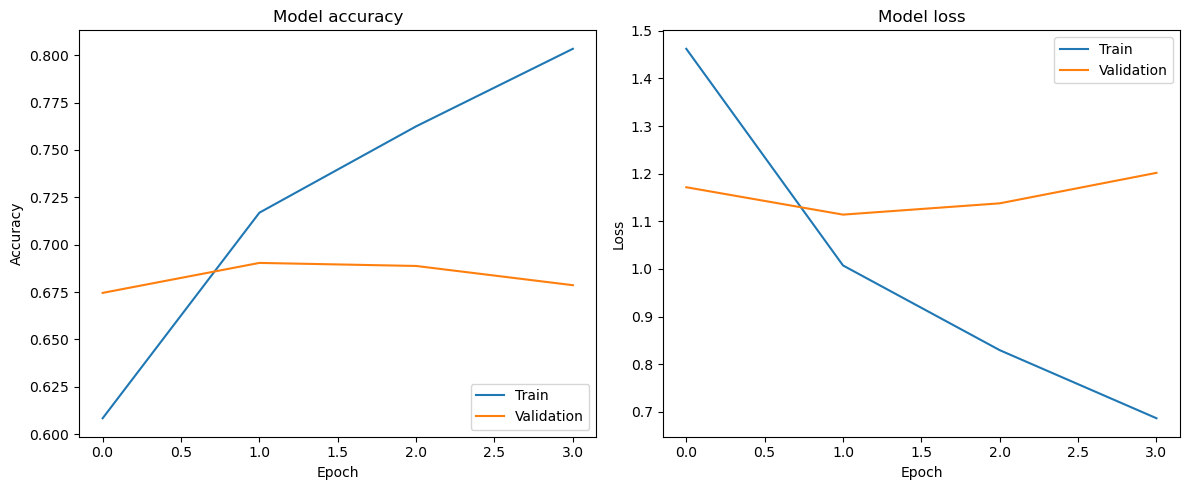

In [213]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.tight_layout()
plt.show()

This model converges very fast to the highest validation accuracy and lowest validation loss. The lowest validation loss was usually on Epoch 2 or 3. I have limited early stopping to 2 additional epochs. Originally I did it much longer but it was observed that in every case when the validation loss reached its minimum, it always continued to steadily rise, so running over more epochs was unnecessary.  

The Keras model was always saved after every epoch when a lowest validation loss was observed, this ensured that the best model configuration was used when running predictions on the test set.

**Save the Model**

In [214]:
# Save the best model
gru1.save('models/gru1.h5')

**Load the best model**  
This is loaded from memory, not from the saved file.

In [215]:
best_gru1 = load_model('best_gru1.h5')

**Run predictions on the test set**

In [216]:
# Predict the classes with the highest probability on the test data
pred_gru1 = best_gru1.predict(X_test_pad)

# The predictions are actually probabilities for each class. 
# The index of the highest probability is the class label the model predicts.
predicted_classes_indices_gru1 = np.argmax(pred_gru1, axis=1)
# Transform the predicted classes back to original class names
predicted_classes_gru1 = label_encoder.inverse_transform(predicted_classes_indices_gru1)  

1310/1310 [==============================] - 132s 100ms/step


In [217]:
# Display the sample classification probabilities for the first element.
pred_gru1[:1]

array([[6.88248361e-03, 2.17099232e-03, 3.06383017e-02, 1.66577958e-02,
        2.24904809e-03, 1.26444118e-03, 2.50894635e-04, 4.32484865e-01,
        3.19890678e-02, 1.38151122e-03, 2.46964488e-03, 2.73534004e-03,
        3.34511837e-03, 6.28390675e-03, 5.68989315e-04, 4.31799889e-03,
        3.69939068e-03, 4.42853896e-03, 4.06965567e-03, 1.18790900e-04,
        3.96816665e-03, 2.06597405e-03, 8.67455639e-03, 8.12155101e-03,
        3.24469000e-01, 1.24103855e-02, 2.93542561e-03, 9.19231400e-03,
        5.76088540e-02, 3.02942656e-03, 9.51760262e-03]], dtype=float32)

In [218]:
# Evaluate the model's performance
loss, accuracy = best_gru1.evaluate(X_test_pad, y_test_one_hot)
print(f'Test accuracy: {accuracy}')
print(f'Test loss: {loss}')

1310/1310 [==============================] - 132s 101ms/step - loss: 1.1063 - accuracy: 0.6932
Test accuracy: 0.6931853294372559
Test loss: 1.1062968969345093


**Display accuracy, precision and recall on the test set**

In [219]:
# 'y_test' are the true classes for the test set.
true_classes = np.array(y_test)  # Ensure it is an array.

# Calculate the metrics
accuracy = metrics.accuracy_score(true_classes, predicted_classes_gru1)
precision = metrics.precision_score(true_classes, predicted_classes_gru1, average='weighted', zero_division=0)
recall = metrics.recall_score(true_classes, predicted_classes_gru1, average='weighted', zero_division=0)
f1_score = metrics.f1_score(true_classes, predicted_classes_gru1, average='weighted', zero_division=0)

# Display the metrics
print(f"Accuracy: {accuracy:.5f}")
print(f"Precision: {precision:.5f}")
print(f"Recall: {recall:.5f}")
print(f"F1-score: {f1_score:.5f}")

Accuracy: 0.69319
Precision: 0.68511
Recall: 0.69319
F1-score: 0.68279


In [220]:
# Display the model's classification accuracy
print(f"Accuracy: {accuracy * 100:.2f}%")

# Display the classification report
sorted_labels = sorted(y_test.unique())
print("\nClassification Report:\n")
print(classification_report(true_classes, predicted_classes_gru1, labels=sorted_labels))

Accuracy: 69.32%

Classification Report:

                    precision    recall  f1-score   support

    ARTS & CULTURE       0.60      0.49      0.54       784
      BLACK VOICES       0.56      0.34      0.42       917
BUSINESS & FINANCE       0.57      0.59      0.58      1549
            COMEDY       0.54      0.49      0.51      1077
             CRIME       0.60      0.53      0.56       712
           DIVORCE       0.84      0.74      0.79       685
         EDUCATION       0.54      0.44      0.49       431
     ENTERTAINMENT       0.67      0.75      0.71      3472
       ENVIRONMENT       0.47      0.59      0.52       813
             FIFTY       0.49      0.20      0.28       279
      FOOD & DRINK       0.77      0.80      0.79      1687
         GOOD NEWS       0.39      0.19      0.26       279
     HOME & LIVING       0.86      0.70      0.77       864
            IMPACT       0.45      0.28      0.34       697
     LATINO VOICES       0.70      0.40      0.51       2

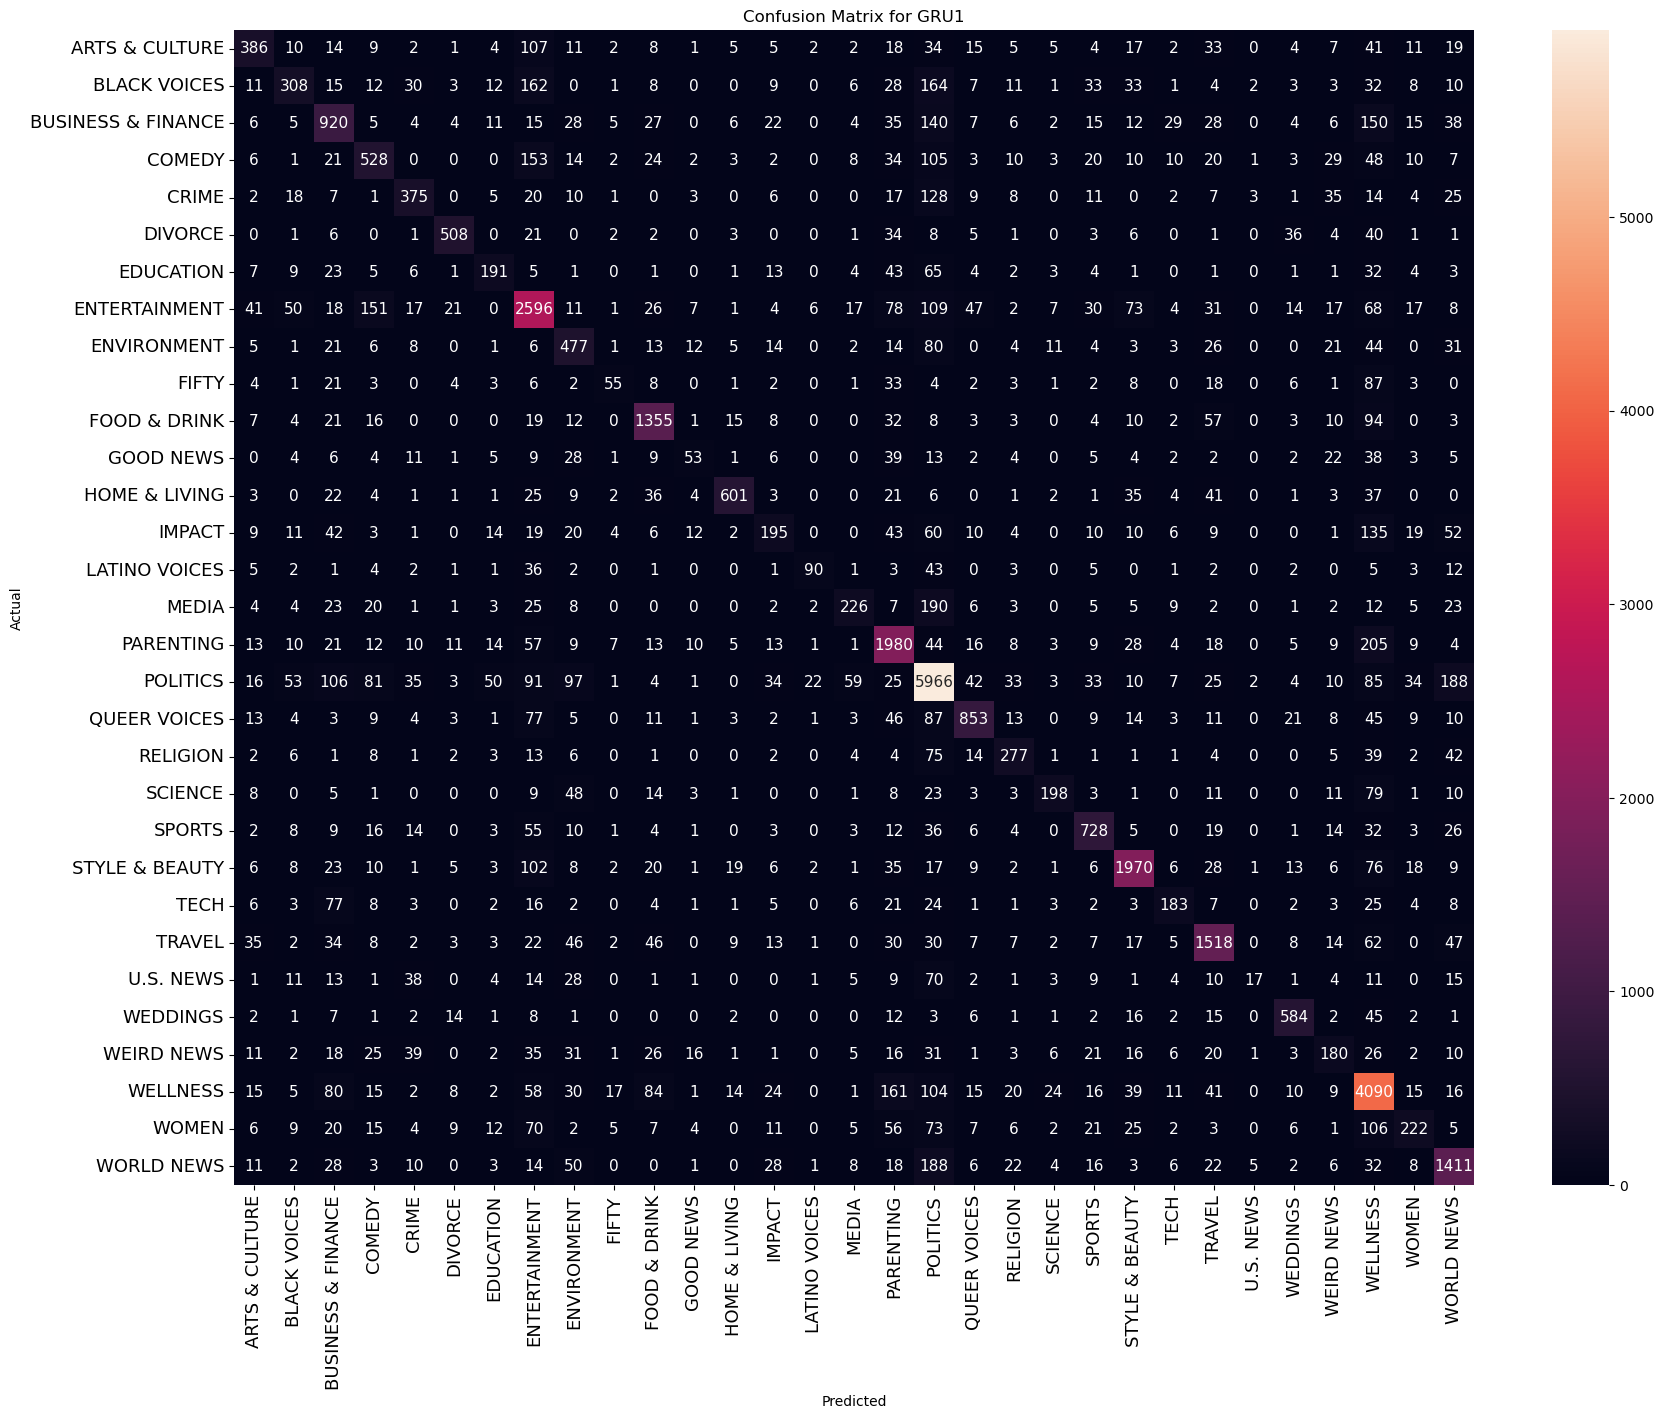

In [221]:
# Generate the confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes_gru1, labels=sorted_labels)

# Plot the confusion matrix
plt.figure(figsize=(20, 15))
sns.heatmap(conf_matrix, annot=True, fmt="d", annot_kws={"size": 11},
            xticklabels=sorted_labels, yticklabels=sorted_labels, cmap="rocket")

# Set the plot configurations
plt.xticks(fontsize=13)
plt.yticks(fontsize=13) 
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix for GRU1')
plt.show()

**Summary of GRU1**

The results here are for the best combination of hyperparameters found after extensive testing. The GRU model has an overall accuracy of 69.32% which is a substantial improvement over the Logistic Regressor which is 66.76%. Slight improvements are seen in most individual cases of precision, recall and F1-score too, indicating that this model is better for predicting minority classes.

### GRU using GloVe - Global Vectors for Word Representation  

GloVe is an unsupervised learning algorithm for obtaining vector representations for words. Training is performed on aggregated global word-word co-occurrence statistics from a corpus, and the resulting representations showcase interesting linear substructures of the word vector space.

https://nlp.stanford.edu/projects/glove/#:~:text=GloVe%20is%20an%20unsupervised%20learning,Getting%20started%20(Code%20download)

Using GloVe embeddings can often lead to better text classification performance and it was evaluated for this project. The GloVe embeddings were first downloaded from the website above and then the text file is loaded into the training below.

**Glove Embeddings**

In [111]:
# Load GloVe embeddings
# Get the working directory
working_directory = os.getcwd()

glove_dir = os.path.join(working_directory, 'glove')
print(f"GloVe directory: {glove_dir}")

glove_file = os.path.join(glove_dir, 'glove.6B.300d.txt')
print(f"Path to the GloVe file: {glove_file}")


GloVe directory: C:\Users\alang\AIT\Project\glove
Path to the GloVe file: C:\Users\alang\AIT\Project\glove\glove.6B.300d.txt


In [112]:
# Credit. Code is based on the following source:
# https://medium.com/analytics-vidhya/basics-of-using-pre-trained-glove-vectors-in-python-d38905f356db

# Create a dictionary to store the GloVe embeddings
embeddings_index = {}

# Open the GloVe file and obtain the embeddings
with open(glove_file, encoding="utf8") as file_object:
    for line in file_object:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

# Display the number of embeddings.
print(f'Found {len(embeddings_index)} word vectors.')

Found 400000 word vectors.


In [113]:
# Create an embedding matrix where each row number corresponds to the index of the word in the tokenizer's word_index
embedding_dim = 300  # This should be the same dimension as the GloVe embeddings in the .txt file
embedding_matrix = np.zeros((vocab_size, embedding_dim))  # vocab_size was determined previously
for word, i in tokenizer.word_index.items():
    if i < max_num_words: # max_words was determined in the tokenization stage.
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector  # words not found in the embedding index will be set to 0.

**Build the Glove GRU Model**

In [114]:
# Define the model parameters
vocab_size = len(tokenizer.word_index) + 1  # Use the entire word index, add 1 because of reserved 0 index
number_of_categories = y_train_one_hot.shape[1]

batch_size = 32  # A common setting
learning_rate = 0.001  # A common setting
patience = 2  # This is for early stopping when the model starts to overtrain.

# RMSProp optimizer was better than Adam
rmsprop_optimizer = RMSprop(learning_rate=learning_rate)

In [115]:
# Build the GRU model with GloVe Embeddings

# GRU bi-directional worked better than just forward.
# Initialize the model structure for a GRU
gru_glove = Sequential()

# Add an embedding layer
gru_glove.add(Embedding(vocab_size, 
                              embedding_dim, 
                              input_length=max_length, 
                              weights=[embedding_matrix],  # Set the pre-trained embedding weights
                              trainable=False))  # Embeddings set to not trainable. This will be faster

# Add the GRU layer. Adding a bi-directional wrapper improved the performance
# Dropout and recurrent dropout worked best at 0.
gru_glove.add(Bidirectional(GRU(units=128, dropout=0, recurrent_dropout=0)))

# Final layer with 'softmax' for multi-class classification
gru_glove.add(Dense(number_of_categories, activation='softmax'))

# Compile the model. RMSProp worked better than Adam
gru_glove.compile(loss='categorical_crossentropy', optimizer=rmsprop_optimizer, metrics=['accuracy'])

In [116]:
# Display the model's summary
gru_glove.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 142, 300)          10901400  
                                                                 
 bidirectional_1 (Bidirectio  (None, 256)              330240    
 nal)                                                            
                                                                 
 dense_1 (Dense)             (None, 31)                7967      
                                                                 
Total params: 11,239,607
Trainable params: 338,207
Non-trainable params: 10,901,400
_________________________________________________________________


**Set the customized callbacks**

In [117]:
# This will estimate the remaining time to process the epoch
time_callback = CustomTimeCallback()

# Set the checkpoint callback to save the best model when validation loss reaches a new minimum
checkpoint = ModelCheckpoint('best_gru_glove.h5', monitor='val_loss', mode='min', save_best_only=True, verbose=1)

# Set early stopping for time efficiency and to prevent excessive overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=patience, verbose=1, restore_best_weights=True)

**Train the Model**

In [118]:
# Train the model with the GloVe embeddings included
history_glove = gru_glove.fit(
    X_train_pad, y_train_one_hot,  
    epochs=30,  # Early stopping will stop the training well before this.
    batch_size=batch_size,
    validation_split=0.2,  # 20% of the train set is used for validation
    callbacks=[early_stop, checkpoint, time_callback]  # Include the callbacks
)

# Get the average time per epoch
times = time_callback.times
average_time_per_epoch = sum(times) / len(times)
print(f'Average time to process an epoch: {round(average_time_per_epoch,1)} seconds')

Epoch 1/30
4190/4190 [==============================] - ETA: 0s - loss: 1.5423 - accuracy: 0.5803
Epoch 1: val_loss improved from inf to 1.34522, saving model to best_gru_glove.h5
4190/4190 [==============================] - 753s 179ms/step - loss: 1.5423 - accuracy: 0.5803 - val_loss: 1.3452 - val_accuracy: 0.6259
Epoch 2/30
4190/4190 [==============================] - ETA: 0s - loss: 1.2560 - accuracy: 0.6458
Epoch 2: val_loss improved from 1.34522 to 1.28352, saving model to best_gru_glove.h5
4190/4190 [==============================] - 718s 171ms/step - loss: 1.2560 - accuracy: 0.6458 - val_loss: 1.2835 - val_accuracy: 0.6404
Epoch 3/30
4190/4190 [==============================] - ETA: 0s - loss: 1.1482 - accuracy: 0.6733
Epoch 3: val_loss improved from 1.28352 to 1.27654, saving model to best_gru_glove.h5
4190/4190 [==============================] - 720s 172ms/step - loss: 1.1482 - accuracy: 0.6733 - val_loss: 1.2765 - val_accuracy: 0.6435
Epoch 4/30
4190/4190 [===================

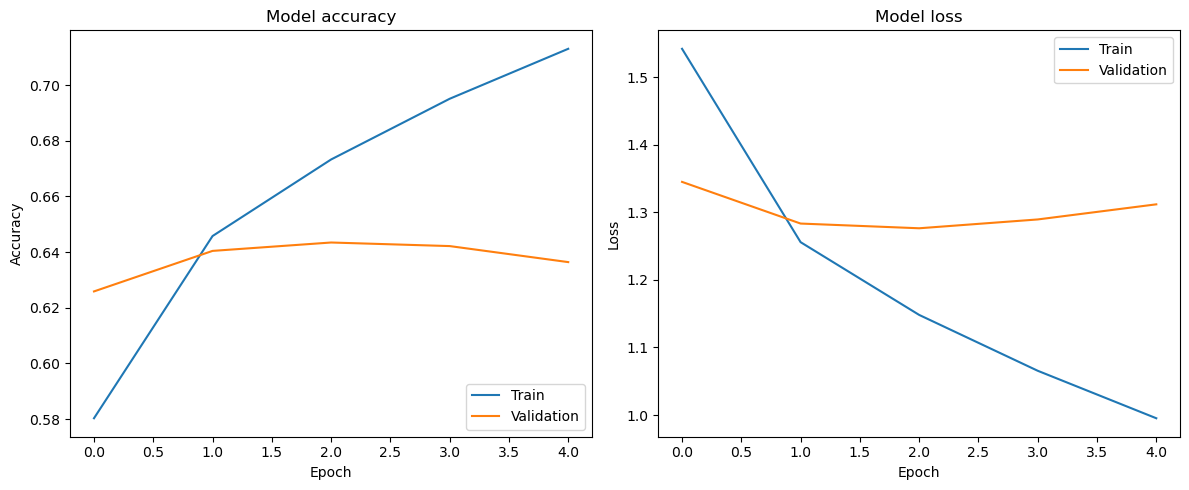

In [119]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_glove.history['accuracy'])
plt.plot(history_glove.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history_glove.history['loss'])
plt.plot(history_glove.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.tight_layout()
plt.show()

Again, early stopping is limited to 2 additional epochs. The Keras model was always saved after every epoch when a lowest validation loss was observed, this ensured that the best model configuration was used when running predictions on the test set. 

Training was very fast, with the lowest validation loss after only 2 epochs.

**Save the Model**

In [120]:
# Save the best model
gru_glove.save('models/gru_glove.h5')

**Load the best model**  
This is loaded from memory, not from the saved file.

In [121]:
best_gru_glove = load_model('best_gru_glove.h5')

**Run predictions on the test set**

In [122]:
# Predict the classes with the highest probability on the test data
pred_gru_glove = best_gru_glove.predict(X_test_pad)

# The predictions are actually probabilities for each class. 
# The index of the highest probability is the class label the model predicts.
predicted_classes_indices_gru_glove = np.argmax(pred_gru_glove, axis=1)
# Transform the predicted classes back to original class names
predicted_classes_gl = label_encoder.inverse_transform(predicted_classes_indices_gru_glove)  

1310/1310 [==============================] - 95s 73ms/step


In [123]:
# Display the sample classification probabilities for the first element.
pred_gru_glove[:1]

array([[2.2021053e-02, 1.0437149e-02, 3.7968308e-03, 6.9160690e-03,
        8.6540368e-04, 5.0363556e-04, 1.5188582e-04, 8.5199988e-01,
        3.1786698e-03, 1.5739242e-03, 2.6238812e-04, 5.3922302e-04,
        2.4112316e-03, 9.9901028e-04, 4.7394322e-04, 1.7341597e-03,
        4.9571251e-04, 9.1088619e-03, 1.6865374e-03, 5.4985296e-04,
        8.5881567e-03, 5.8534197e-03, 1.0865323e-03, 6.9079185e-03,
        3.3276685e-02, 6.8161478e-03, 3.4116593e-03, 1.1555481e-03,
        9.9530434e-03, 4.7101619e-04, 2.7743632e-03]], dtype=float32)

In [124]:
# Evaluate the model's performance
loss, accuracy = best_gru_glove.evaluate(X_test_pad, y_test_one_hot)
print(f'Test accuracy: {accuracy}')
print(f'Test loss: {loss}')

1310/1310 [==============================] - 96s 73ms/step - loss: 1.2731 - accuracy: 0.6458
Test accuracy: 0.6457810997962952
Test loss: 1.2731106281280518


**Display accuracy, precision and recall on the test set**

In [125]:
# Calculate the metrics
accuracy = metrics.accuracy_score(true_classes, predicted_classes_gl)
precision = metrics.precision_score(true_classes, predicted_classes_gl, average='weighted', zero_division=0)
recall = metrics.recall_score(true_classes, predicted_classes_gl, average='weighted', zero_division=0)
f1_score = metrics.f1_score(true_classes, predicted_classes_gl, average='weighted', zero_division=0)

# Display the metrics
print(f"Accuracy: {accuracy:.5f}")
print(f"Precision: {precision:.5f}")
print(f"Recall: {recall:.5f}")
print(f"F1-score: {f1_score:.5f}")

Accuracy: 0.64578
Precision: 0.63500
Recall: 0.64578
F1-score: 0.63100


In [126]:
# Display the model's classification accuracy
print(f"Accuracy: {accuracy * 100:.2f}%")

# Display the classification report
sorted_labels = sorted(y_test.unique())
print("\nClassification Report:\n")
print(classification_report(true_classes, predicted_classes_gl, labels=sorted_labels))

Accuracy: 64.58%

Classification Report:

                    precision    recall  f1-score   support

    ARTS & CULTURE       0.50      0.48      0.49       784
      BLACK VOICES       0.54      0.28      0.37       917
BUSINESS & FINANCE       0.52      0.52      0.52      1549
            COMEDY       0.63      0.32      0.43      1077
             CRIME       0.51      0.51      0.51       712
           DIVORCE       0.52      0.46      0.49       685
         EDUCATION       0.52      0.33      0.40       431
     ENTERTAINMENT       0.59      0.75      0.66      3472
       ENVIRONMENT       0.46      0.48      0.47       813
             FIFTY       0.35      0.06      0.11       279
      FOOD & DRINK       0.71      0.77      0.74      1687
         GOOD NEWS       0.44      0.11      0.18       279
     HOME & LIVING       0.71      0.68      0.69       864
            IMPACT       0.36      0.24      0.29       697
     LATINO VOICES       0.76      0.31      0.44       2

**Summary of GRU_Glove**

Clearly GloVe did not work as well for this dataset as the standard GRU model. This is likely due to the shorter word sequences. It was approximately 5% worse than the standard text preprocessing.

#### Word2Vec GRU

Word2vec is another NLP technique in which words from a large vocabulary are mapped into vectors of integers. This embedding enables words with similar semantic meaning to be represented by the same vector. This often leads to enhanced performance in NLP. Word2vec was originally developed at Google in 2013.

https://towardsdatascience.com/introduction-to-word-embedding-and-word2vec-652d0c2060fa

Word2vec is another embedding technique that was evaluated in this project.

**Create the Word2Vec embedding matrix**

In [127]:
from gensim.models import Word2Vec

In [128]:
# Set random seed for reproducibility
seed = 12
np.random.seed(seed)
random.seed(seed)

In [129]:
# Create word tokens using Gensim
X_train_tokens = [gensim.utils.simple_preprocess(sentence) for sentence in X_train]
X_test_tokens = [gensim.utils.simple_preprocess(sentence) for sentence in X_test]

In [130]:
# Train the Word2Vec model
word2vec_model = Word2Vec(sentences=X_train_tokens, vector_size=100, window=5, min_count=1, workers=4, seed=seed)

# Save the model
word2vec_model.save("models/word2vec_model.model")

In [131]:
# Create the Word2Vec embedding matrix

word_vector_dim = 100  # This number must match the vector_size parameter in the Word2Vec model
# Create an intital matrix of the right dimensions
embedding_matrix_w2v = np.zeros((vocab_size, word_vector_dim))

# This fills the embedding matrix with vectors from the Word2Vec model
# that correspond to each word in the tokenizer's vocabulary set.
for word, i in tokenizer.word_index.items():
    if word in word2vec_model.wv.key_to_index:
        embedding_matrix_w2v[i] = word2vec_model.wv[word]

**Build the Word2Vec Model**

In [132]:
# Define the model parameters
vocab_size = len(tokenizer.word_index) + 1  # Use the entire word index, add 1 because of reserved 0 index
embedding_dim = 100
number_of_categories = y_train_one_hot.shape[1]

batch_size = 32  # A common setting
learning_rate = 0.001  # A common setting
patience = 2  # This is for early stopping when the model starts to overtrain.

# RMSProp optimizer worked better than Adam
rmsprop_optimizer = RMSprop(learning_rate=learning_rate)

In [133]:
# Build the GRU model with Word2Vec Embeddings

# Initialize the model structure for a GRU
gru_w2v = Sequential()

# Add an embedding layer
gru_w2v.add(Embedding(vocab_size, 
                           word_vector_dim, 
                           input_length=max_length, 
                           weights=[embedding_matrix_w2v],  # Set the pre-trained embedding weights
                           trainable=False))  # Embeddings are set to 'not trainable'. This will be faster.

# Add the GRU layer. Adding a bi-directional wrapper improved the performance
# Dropout and recurrent dropout worked best at 0.
gru_w2v.add(Bidirectional(GRU(units=128, dropout=0, recurrent_dropout=0)))

# Add the final layer with 'softmax' for multi-class classification
gru_w2v.add(Dense(number_of_categories, activation='softmax'))

# Compile the model
gru_w2v.compile(loss='categorical_crossentropy', optimizer=rmsprop_optimizer, metrics=['accuracy'])

In [134]:
# Display the model's summary
gru_w2v.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 142, 100)          3633800   
                                                                 
 bidirectional_2 (Bidirectio  (None, 256)              176640    
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 31)                7967      
                                                                 
Total params: 3,818,407
Trainable params: 184,607
Non-trainable params: 3,633,800
_________________________________________________________________


**Set the customized callbacks**

In [135]:
# This will estimate the remaining time to process the epoch
time_callback = CustomTimeCallback()

# Set the checkpoint callback to save the best model when validation loss reaches a new minimum
checkpoint = ModelCheckpoint('best_w2v.h5', monitor='val_loss', mode='min', save_best_only=True, verbose=1)

# Set early stopping for time efficiency and to prevent excessive overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=patience, verbose=1, restore_best_weights=True)

**Train the Model**

In [136]:
# Train the model
history_w2v = gru_w2v.fit(
    X_train_pad, y_train_one_hot,  
    epochs=10,
    batch_size=batch_size,
    validation_split=0.2, # 20% of the train set is used for validation
    callbacks=[early_stop, checkpoint, time_callback]
)

# Get the average time per epoch
times = time_callback.times
average_time_per_epoch = sum(times) / len(times)
print()
print(f'Average time to process an epoch: {round(average_time_per_epoch,1)} seconds')

Epoch 1/10
4190/4190 [==============================] - ETA: 0s - loss: 1.4413 - accuracy: 0.5997
Epoch 1: val_loss improved from inf to 1.29771, saving model to best_w2v.h5
4190/4190 [==============================] - 703s 167ms/step - loss: 1.4413 - accuracy: 0.5997 - val_loss: 1.2977 - val_accuracy: 0.6339
Epoch 2/10
4190/4190 [==============================] - ETA: 0s - loss: 1.2471 - accuracy: 0.6461
Epoch 2: val_loss improved from 1.29771 to 1.24961, saving model to best_w2v.h5
4190/4190 [==============================] - 698s 167ms/step - loss: 1.2471 - accuracy: 0.6461 - val_loss: 1.2496 - val_accuracy: 0.6467
Epoch 3/10
4190/4190 [==============================] - ETA: 0s - loss: 1.1762 - accuracy: 0.6631
Epoch 3: val_loss improved from 1.24961 to 1.23581, saving model to best_w2v.h5
4190/4190 [==============================] - 695s 166ms/step - loss: 1.1762 - accuracy: 0.6631 - val_loss: 1.2358 - val_accuracy: 0.6475
Epoch 4/10
4190/4190 [==============================] - ETA

**Training Evaluation**

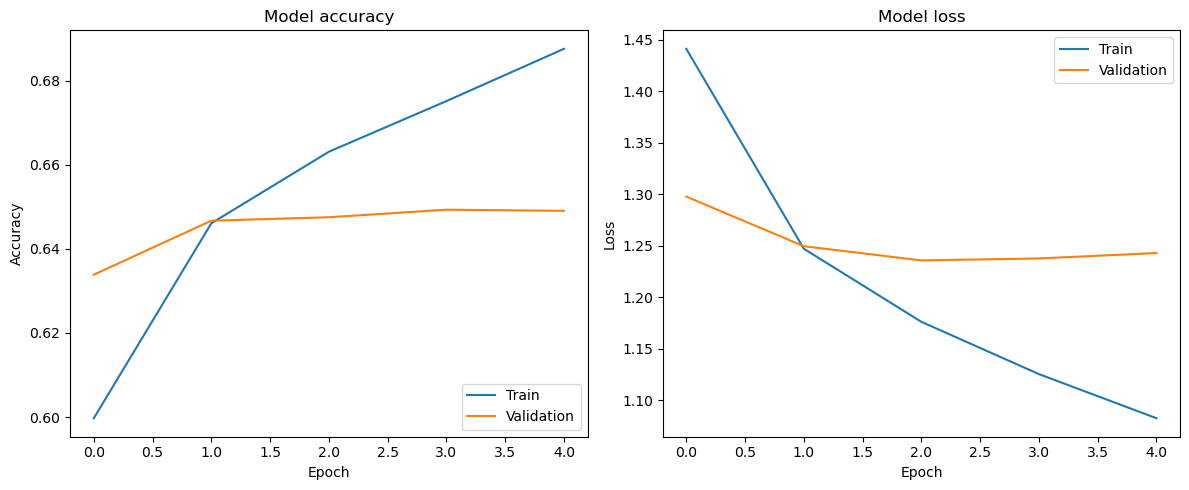

In [137]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_w2v.history['accuracy'])
plt.plot(history_w2v.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history_w2v.history['loss'])
plt.plot(history_w2v.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.tight_layout()
plt.show()

Again, early stopping is limited to 2 additional epochs. The Keras model was always saved after every epoch when a lowest validation loss was observed, this ensured that the best model configuration was used when running predictions on the test set. 

Training was very fast, with the lowest validation loss after only 2 epochs.

**Save the Model**

In [138]:
# Save the best model
gru_w2v.save('models/gru_w2v.h5')

**Load the best model**  
This is loaded from memory, not the saved file.

In [139]:
best_gru_w2v = load_model('best_w2v.h5')

**Run predictions on the test set**

In [140]:
# Predict the classes with the highest probability on the test data
pred_gru_w2v = best_gru_w2v.predict(X_test_pad)

# The predictions are actually probabilities for each class. 
# The index of the highest probability is the class label the model predicts.
predicted_classes_indices_gru_w2v = np.argmax(pred_gru_w2v, axis=1)
# Transform the predicted classes back to original class names
predicted_classes_gru_w2v = label_encoder.inverse_transform(predicted_classes_indices_gru_w2v)

1310/1310 [==============================] - 97s 74ms/step


In [141]:
pred_gru_w2v[:1]
#predicted_classes_indices

array([[1.47846848e-01, 1.02360165e-02, 3.14478716e-03, 1.91937294e-02,
        4.91915504e-04, 6.10795629e-04, 7.27611186e-05, 5.40909231e-01,
        6.94706803e-03, 3.53709795e-03, 1.16668816e-03, 1.51849876e-03,
        1.25585133e-02, 2.33735633e-03, 3.60578788e-03, 2.40432052e-03,
        1.28576963e-03, 4.61968407e-03, 1.06718605e-02, 3.58532212e-04,
        2.33741640e-03, 4.80574556e-03, 1.18287595e-03, 4.75163758e-03,
        1.94703087e-01, 3.98956332e-03, 1.29713141e-03, 9.33233008e-04,
        9.59945098e-03, 4.85777127e-04, 2.39677378e-03]], dtype=float32)

In [142]:
# Evaluate the model's performance
loss, accuracy = best_gru_w2v.evaluate(X_test_pad, y_test_one_hot)
print(f'Test accuracy: {accuracy}')
print(f'Test loss: {loss}')

1310/1310 [==============================] - 91s 69ms/step - loss: 1.2242 - accuracy: 0.6493
Test accuracy: 0.649337649345398
Test loss: 1.2242473363876343


**Display accuracy, precision and recall on the test set**

In [143]:
# 'y_test' are the true classes for the test set.
true_classes = np.array(y_test)  # Ensure it is an array.

accuracy = metrics.accuracy_score(true_classes, predicted_classes_gru_w2v)
precision = metrics.precision_score(true_classes, predicted_classes_gru_w2v, average='weighted', zero_division=0)
recall = metrics.recall_score(true_classes, predicted_classes_gru_w2v, average='weighted', zero_division=0)
f1_score = metrics.f1_score(true_classes, predicted_classes_gru_w2v, average='weighted', zero_division=0)

# Display the metrics
print(f"Accuracy: {accuracy:.5f}")
print(f"Precision: {precision:.5f}")
print(f"Recall: {recall:.5f}")
print(f"F1-score: {f1_score:.5f}")


Accuracy: 0.64934
Precision: 0.63729
Recall: 0.64934
F1-score: 0.63193


In [144]:
# Display the model's classification accuracy
print(f"Accuracy: {accuracy * 100:.2f}%")

# Display the classification report
sorted_labels = sorted(y_test.unique())
print("\nClassification Report:\n")
print(classification_report(true_classes, predicted_classes_gru_w2v, labels=sorted_labels))

Accuracy: 64.93%

Classification Report:

                    precision    recall  f1-score   support

    ARTS & CULTURE       0.45      0.45      0.45       784
      BLACK VOICES       0.52      0.25      0.34       917
BUSINESS & FINANCE       0.53      0.55      0.54      1549
            COMEDY       0.58      0.34      0.43      1077
             CRIME       0.51      0.54      0.52       712
           DIVORCE       0.74      0.70      0.72       685
         EDUCATION       0.48      0.35      0.41       431
     ENTERTAINMENT       0.58      0.72      0.65      3472
       ENVIRONMENT       0.45      0.41      0.43       813
             FIFTY       0.31      0.03      0.05       279
      FOOD & DRINK       0.74      0.78      0.76      1687
         GOOD NEWS       0.38      0.08      0.14       279
     HOME & LIVING       0.74      0.68      0.71       864
            IMPACT       0.34      0.25      0.29       697
     LATINO VOICES       1.00      0.01      0.02       2

**Summary of GRU_Word2Vec**

Clearly Word2Vec did not work as well for this dataset as the standard GRU model. This is likely due to the shorter word sequences. It was approximately 4.5% worse than the standard text preprocessing.

### LSTM Long-Short Term Memory  
A LSTM is a type of RNN with a more complex architecture than a GRU. It was evaluated to see if this more complex model would yield improved results.

**Build the LSTM Model**

In [145]:
# Define the model parameters
vocab_size = len(tokenizer.word_index) + 1  # Use the entire word index, add 1 because of reserved 0 index
embedding_dim = 1000  # After much experimentation, 1000 worked the best.
number_of_categories = y_train_one_hot.shape[1]

batch_size = 32  # A common setting
learning_rate = 0.001  # A common setting
patience = 2  # This is for early stopping when the model starts to overtrain.

# Adam and RMSProp optimizers were tried
adam_optimizer = Adam(learning_rate=learning_rate)
rmsprop_optimizer = RMSprop(learning_rate=learning_rate)

In [146]:
# Build the LSTM model

# For the LSTM, bi-directional worked better than just forward.
# Initialize the model structure for a LSTM
lstm1 = Sequential()

# Add an embedding layer
lstm1.add(Embedding(vocab_size, embedding_dim, input_length=max_length))

# Add the LSTM layer. Adding a bi-directional wrapper improved the performance.
# Dropout and recurrent dropout worked best at 0.
lstm1.add(Bidirectional(LSTM(units=128, dropout=0, recurrent_dropout=0)))

# Add an additional Dense layer with ReLU activation
#lstm1.add(Dense(64, activation='relu'))

# Add the final layer with 'softmax' for multi-class classification
lstm1.add(Dense(number_of_categories, activation='softmax'))

# Compile the model
lstm1.compile(loss='categorical_crossentropy', optimizer=rmsprop_optimizer, metrics=['accuracy'])

In [147]:
# Display the model's summary
lstm1.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 142, 1000)         36338000  
                                                                 
 bidirectional_3 (Bidirectio  (None, 256)              1156096   
 nal)                                                            
                                                                 
 dense_3 (Dense)             (None, 31)                7967      
                                                                 
Total params: 37,502,063
Trainable params: 37,502,063
Non-trainable params: 0
_________________________________________________________________


**The callback method is the same as for the GRU**  
The code won't be repeated here.

**Set the customized callbacks**

In [148]:
# This will estimate the remaining time to process the epoch
time_callback = CustomTimeCallback()

# Set the checkpoint callback to save the best model when validation loss reaches a new minimum
checkpoint = ModelCheckpoint('best_lstm1.h5', monitor='val_loss', mode='min', save_best_only=True, verbose=1)

# Set early stopping for time efficiency and to prevent excessive overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=patience, verbose=1, restore_best_weights=True)

**Train the Model**

In [149]:
# Train the model

history2 = lstm1.fit(
    X_train_pad, y_train_one_hot,
    epochs=30,
    batch_size = batch_size,
    validation_split=0.2, # 20%  is used for validation
    callbacks=[early_stop, checkpoint, time_callback]
)

# Get the average time per epoch
times = time_callback.times
average_time_per_epoch = sum(times) / len(times)
print()
print(f'Average time to process an epoch: {round(average_time_per_epoch,1)} seconds')

Epoch 1/30
4190/4190 [==============================] - ETA: 0s - loss: 1.4531 - accuracy: 0.6092
Epoch 1: val_loss improved from inf to 1.17337, saving model to best_lstm1.h5
4190/4190 [==============================] - 1059s 252ms/step - loss: 1.4531 - accuracy: 0.6092 - val_loss: 1.1734 - val_accuracy: 0.6765
Epoch 2/30
4190/4190 [==============================] - ETA: 0s - loss: 0.9914 - accuracy: 0.7204
Epoch 2: val_loss improved from 1.17337 to 1.12364, saving model to best_lstm1.h5
4190/4190 [==============================] - 1044s 249ms/step - loss: 0.9914 - accuracy: 0.7204 - val_loss: 1.1236 - val_accuracy: 0.6896
Epoch 3/30
4190/4190 [==============================] - ETA: 0s - loss: 0.7979 - accuracy: 0.7708
Epoch 3: val_loss did not improve from 1.12364
4190/4190 [==============================] - 1055s 252ms/step - loss: 0.7979 - accuracy: 0.7708 - val_loss: 1.1418 - val_accuracy: 0.6908
Epoch 4/30
4190/4190 [==============================] - ETA: 0s - loss: 0.6471 - accu

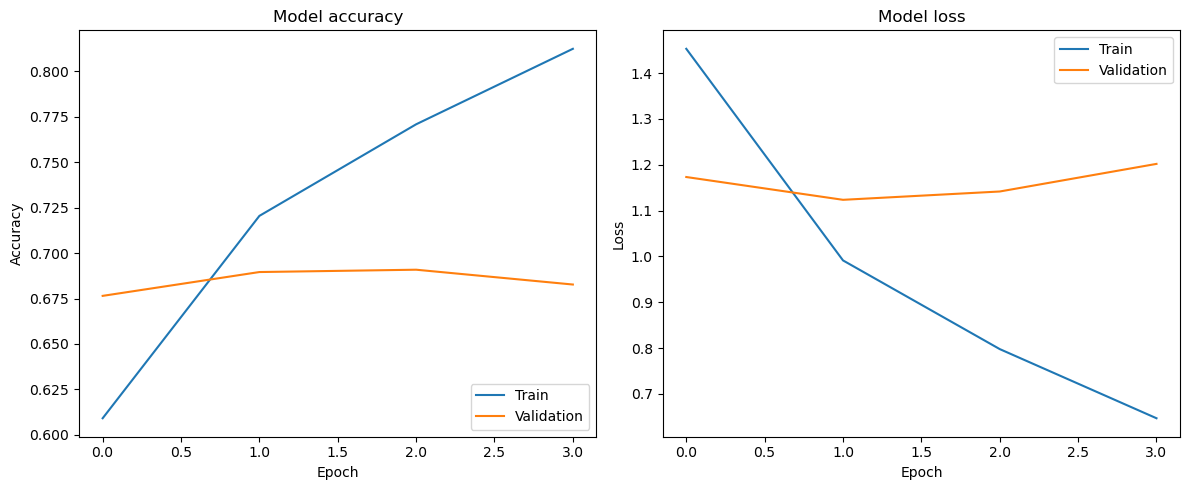

In [150]:
# Plot training & validation accuracy progress
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.tight_layout()
plt.show()

Again, early stopping is limited to 2 additional epochs. The Keras model was always saved after every epoch when a lowest validation loss was observed, this ensured that the best model configuration was used when running predictions on the test set.

Training was very fast, with the lowest validation loss after only 2 epochs.

**Save the model**

In [151]:
# Save the model
lstm1.save('models/lstm1.h5')

**Load the best model**  
This is loaded from memory, not from the saved file.

In [152]:
best_lstm1 = load_model('best_lstm1.h5')

**Run predictions on the test set**

In [153]:
# Predict the classes with the highest probability on the test data
pred_lstm1 = best_lstm1.predict(X_test_pad)

# The predictions are actually probabilities for each class. 
# The index of the highest probability is the class label that the model predicts.
predicted_classes_indices_lstm1 = np.argmax(pred_lstm1, axis=1)
# Transform the predicted classes back to original class names
predicted_classes_lstm1 = label_encoder.inverse_transform(predicted_classes_indices_lstm1)


1310/1310 [==============================] - 88s 67ms/step


In [154]:
# Display the predicted probabilities of classes for the first sample.
pred_lstm1[:1]

array([[4.68826368e-02, 6.06078794e-03, 1.94055196e-02, 5.56601547e-02,
        2.96226772e-03, 1.08733855e-03, 1.89023127e-03, 3.42692137e-01,
        7.47609138e-02, 4.89811273e-03, 2.91464734e-03, 1.63620524e-03,
        3.13290744e-03, 6.86920155e-03, 2.17413806e-04, 1.43137074e-03,
        1.63891003e-03, 8.57932772e-03, 1.82929542e-03, 3.59923957e-04,
        1.37200905e-02, 2.20684404e-03, 1.99177377e-02, 1.49229867e-03,
        3.37285936e-01, 1.57489385e-02, 1.12229853e-03, 3.92767694e-03,
        1.24354903e-02, 2.25895597e-03, 4.97443322e-03]], dtype=float32)

In [155]:
# Evaluate the model's performance
loss, accuracy = lstm1.evaluate(X_test_pad, y_test_one_hot)
print(f'Test accuracy: {accuracy}')

1310/1310 [==============================] - 89s 68ms/step - loss: 1.1157 - accuracy: 0.6915
Test accuracy: 0.6915144920349121


**Display accuracy, precision and recall on the test set**

In [156]:
# 'y_test' are the true classes for the test set.
true_classes = np.array(y_test)  # Ensure it is an array.

accuracy = metrics.accuracy_score(true_classes, predicted_classes_lstm1)
precision = metrics.precision_score(true_classes, predicted_classes_lstm1, average='weighted', zero_division=0)
recall = metrics.recall_score(true_classes, predicted_classes_lstm1, average='weighted', zero_division=0)
f1_score = metrics.f1_score(true_classes, predicted_classes_lstm1, average='weighted', zero_division=0)

# Display the metrics
print(f"Accuracy: {accuracy:.5f}")
print(f"Precision: {precision:.5f}")
print(f"Recall: {recall:.5f}")
print(f"F1-score: {f1_score:.5f}")

Accuracy: 0.69151
Precision: 0.68131
Recall: 0.69151
F1-score: 0.68114


In [157]:
# Display the model's classification accuracy
#accuracy = accuracy_score(y_test, y_pred_lr1)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Displaying the classification report
sorted_labels = sorted(y_test.unique())
print("\nClassification Report:\n")
print(classification_report(true_classes, predicted_classes_lstm1, labels=sorted_labels))

Accuracy: 69.15%

Classification Report:

                    precision    recall  f1-score   support

    ARTS & CULTURE       0.58      0.51      0.54       784
      BLACK VOICES       0.53      0.35      0.42       917
BUSINESS & FINANCE       0.59      0.58      0.58      1549
            COMEDY       0.51      0.52      0.52      1077
             CRIME       0.59      0.50      0.54       712
           DIVORCE       0.83      0.74      0.78       685
         EDUCATION       0.51      0.45      0.48       431
     ENTERTAINMENT       0.66      0.74      0.70      3472
       ENVIRONMENT       0.48      0.57      0.52       813
             FIFTY       0.38      0.24      0.29       279
      FOOD & DRINK       0.75      0.81      0.78      1687
         GOOD NEWS       0.39      0.15      0.22       279
     HOME & LIVING       0.84      0.73      0.78       864
            IMPACT       0.47      0.28      0.35       697
     LATINO VOICES       0.65      0.43      0.52       2

**Confusion Matrix**

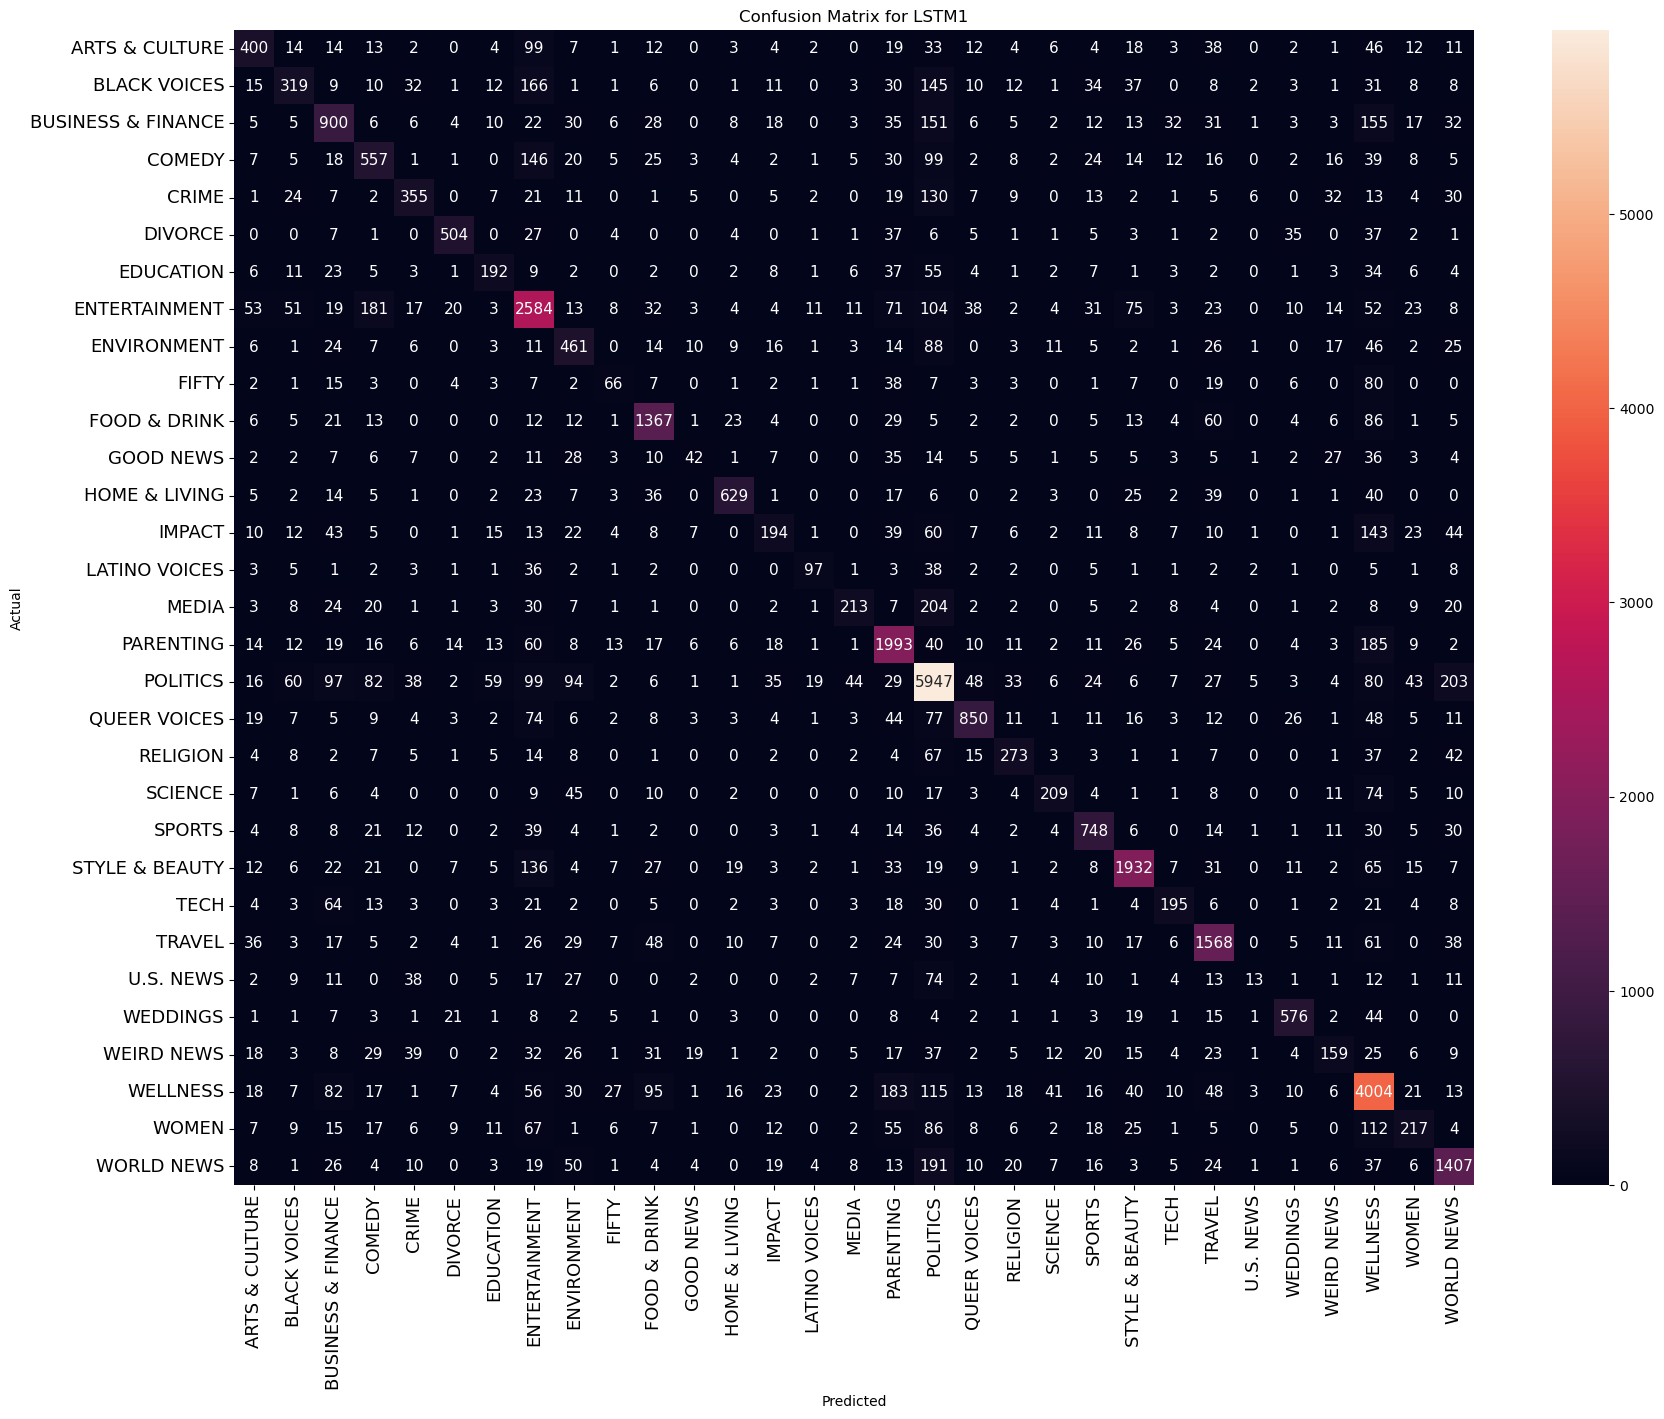

In [158]:
# Generate the confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes_lstm1, labels=sorted_labels)

# Plot the confusion matrix
plt.figure(figsize=(20, 15))
sns.heatmap(conf_matrix, annot=True, fmt="d", annot_kws={"size": 11},
            xticklabels=sorted_labels, yticklabels=sorted_labels, cmap="rocket")

# Set the plot configurations
plt.xticks(fontsize=13)
plt.yticks(fontsize=13) 
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix for LSTM1')
plt.show()

**Summary of LSTM1**

The performance of the best LSTM (69.15%) is a good improvement over the baseline, however the GRU model was slightly more accurate for the best setting of hyperparameters (69.32%). The GRU model was always consistently more accurate than the LSTM when the same hyperparameters and preprocessing parameters were used. With a mean word count of 29 words per article, these sequences are fairly short. LSTMs are designed to handle much longer sequences.

### LSTM GLOVE

GloVe was also evaluated on the LSTM to see if any improvemnets could be gained.

In [159]:
# Define the model parameters
vocab_size = len(tokenizer.word_index) + 1  # Add 1 because of reserved 0 index
embedding_dim = 300  # This should be the same dimension as the GloVe embeddings in the .txt file
batch_size = 32
learning_rate = 0.001
patience = 2  # This is for early stopping when the model starts to overtrain.

# Early stopping to prevent overtraining
early_stop = EarlyStopping(monitor='val_loss', patience=patience, verbose=1, restore_best_weights=True)
number_of_categories = y_train_one_hot.shape[1]

# RMSProp optimizer worked better than Adam
rmsprop_optimizer = RMSprop(learning_rate=learning_rate)

In [160]:
# Build the LSTM model with GloVe Embeddings

# LSTM bi-directional worked better than just forward.
# Initialize the model structure for a GRU
lstm_glove = Sequential()

# Add an embedding layer
lstm_glove.add(Embedding(vocab_size, 
                         embedding_dim, 
                         input_length=max_length, 
                         weights=[embedding_matrix],  # Set pre-trained embedding weights
                         trainable=False))  # Embeddings are set to not trainable. This will be faster

# Add the LSTM layer. Adding a bi-directional wrapper improved the performance
# Dropout and recurrent dropout worked best at 0.
lstm_glove.add(Bidirectional(LSTM(units=128, dropout=0.0, recurrent_dropout=0.0)))

# Final layer with 'softmax' for multi-class classification
lstm_glove.add(Dense(number_of_categories, activation='softmax'))

# Compile the model. RMSProp worked better than Adam
lstm_glove.compile(loss='categorical_crossentropy', optimizer=rmsprop_optimizer, metrics=['accuracy'])


In [161]:
# Display the model's summary
lstm_glove.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 142, 300)          10901400  
                                                                 
 bidirectional_4 (Bidirectio  (None, 256)              439296    
 nal)                                                            
                                                                 
 dense_4 (Dense)             (None, 31)                7967      
                                                                 
Total params: 11,348,663
Trainable params: 447,263
Non-trainable params: 10,901,400
_________________________________________________________________


**Set the customized callbacks**

In [162]:
# This will estimate the remaining time to process the epoch
time_callback = CustomTimeCallback()

# Set the checkpoint callback to save the best model when validation loss reaches a new minimum
checkpoint = ModelCheckpoint('best_lstm1_glove.h5', monitor='val_loss', mode='min', save_best_only=True, verbose=1, save_weights_only=False)

# Set early stopping for time efficiency and to prevent excessive overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=patience, verbose=1, restore_best_weights=True)

**Train the Model**

In [163]:
# Train the model with the GloVe embeddings included
history_lstm_glove = lstm_glove.fit(
    X_train_pad, y_train_one_hot,  
    epochs=30,  # Early stopping will stop the training well before this.
    batch_size=batch_size,
    validation_split=0.2,  # 20% of the train set is used for validation
    callbacks=[early_stop, checkpoint, time_callback]  # Include the callbacks
)

# Calculate the average time per epoch
times = time_callback.times
average_time_per_epoch = sum(times) / len(times)
print()
print(f'Average time to process an epoch: {round(average_time_per_epoch,1)} seconds')

Epoch 1/30
4190/4190 [==============================] - ETA: 0s - loss: 1.5540 - accuracy: 0.5768
Epoch 1: val_loss improved from inf to 1.37124, saving model to best_lstm1_glove.h5
4190/4190 [==============================] - 668s 159ms/step - loss: 1.5540 - accuracy: 0.5768 - val_loss: 1.3712 - val_accuracy: 0.6225
Epoch 2/30
4190/4190 [==============================] - ETA: 0s - loss: 1.2663 - accuracy: 0.6437
Epoch 2: val_loss improved from 1.37124 to 1.30258, saving model to best_lstm1_glove.h5
4190/4190 [==============================] - 644s 154ms/step - loss: 1.2663 - accuracy: 0.6437 - val_loss: 1.3026 - val_accuracy: 0.6359
Epoch 3/30
4190/4190 [==============================] - ETA: 0s - loss: 1.1454 - accuracy: 0.6737
Epoch 3: val_loss improved from 1.30258 to 1.28702, saving model to best_lstm1_glove.h5
4190/4190 [==============================] - 651s 155ms/step - loss: 1.1454 - accuracy: 0.6737 - val_loss: 1.2870 - val_accuracy: 0.6422
Epoch 4/30
4190/4190 [=============

**Training Evaluation**

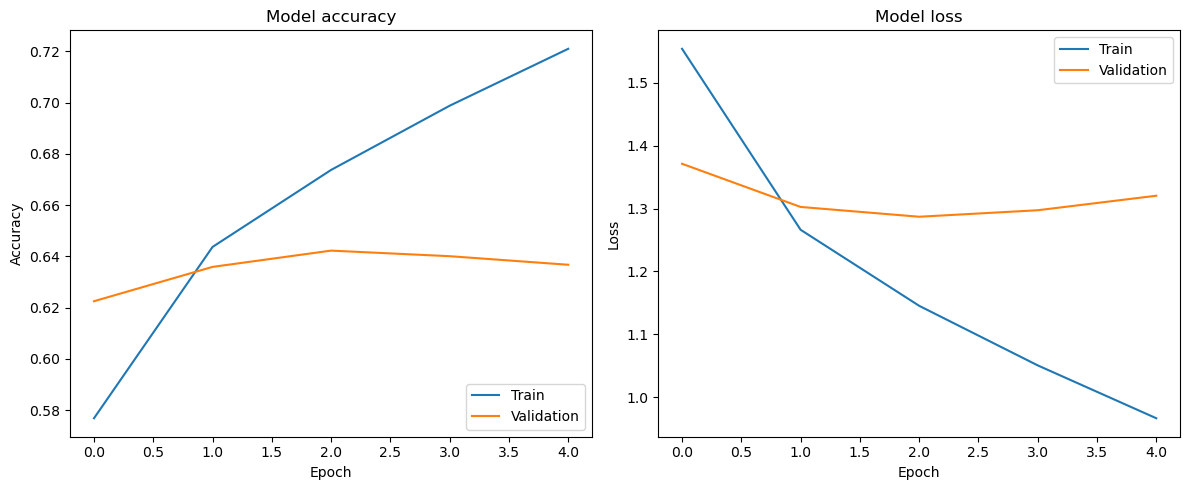

In [164]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_lstm_glove.history['accuracy'])
plt.plot(history_lstm_glove.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history_lstm_glove.history['loss'])
plt.plot(history_lstm_glove.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.tight_layout()
plt.show()

Again, early stopping is limited to 2 additional epochs. The Keras model was always saved after every epoch when a lowest validation loss was observed, this ensured that the best model configuration was used when running predictions on the test set.

Training was very fast, with the lowest validation loss after only 2 epochs.

**Save the Model**

In [165]:
# Save the best model
lstm_glove.save('models/lstm_glove.h5')

**Load the best model**  
This is loaded from memory, not from the saved file.

In [166]:
best_lstm_glove = load_model('best_lstm1_glove.h5')

**Run predictions on the test set**

In [167]:
# Predict the classes with the highest probability on the test data
pred_lstm_glove = best_lstm_glove.predict(X_test_pad)

# The predictions are actually probabilities for each class. 
# The index of the highest probability is the class label the model predicts.
predicted_classes_indices_lstm_glove = np.argmax(pred_lstm_glove, axis=1)
# Transform the predicted classes back to original class names
predicted_classes_lstm_glove = label_encoder.inverse_transform(predicted_classes_indices_lstm_glove)  

1310/1310 [==============================] - 94s 72ms/step


In [168]:
# Display the sample classification probabilities for the first element.
pred_gru1[:1]

array([[2.4922319e-02, 3.0619008e-03, 1.2984906e-02, 3.6015324e-02,
        8.6234190e-04, 1.0606642e-03, 1.6785058e-04, 5.3844690e-01,
        6.1038777e-02, 5.0370378e-04, 9.2936140e-03, 4.2982046e-03,
        4.8566284e-03, 1.0525842e-02, 5.3946377e-04, 2.5089334e-03,
        7.9765189e-03, 5.8884164e-03, 2.8368854e-03, 5.0210097e-04,
        1.0095896e-02, 5.9885569e-03, 1.4340512e-02, 2.4082294e-02,
        1.1581437e-01, 7.3726783e-03, 1.0188443e-03, 8.2786046e-03,
        5.1239979e-02, 6.1459788e-03, 2.7331069e-02]], dtype=float32)

In [169]:
# Evaluate the model's performance
loss, accuracy = best_gru1.evaluate(X_test_pad, y_test_one_hot)
print(f'Test accuracy: {accuracy}')
print(f'Test loss: {loss}')

1310/1310 [==============================] - 114s 87ms/step - loss: 1.1033 - accuracy: 0.6928
Test accuracy: 0.6928034424781799
Test loss: 1.1032944917678833


**Display accuracy, precision and recall on the test set**

In [170]:
# 'y_test' are the true classes for the test set.
true_classes = np.array(y_test)  # Ensure it is an array.

# Calculate the metrics
accuracy = metrics.accuracy_score(true_classes, predicted_classes_lstm_glove)
precision = metrics.precision_score(true_classes, predicted_classes_lstm_glove, average='weighted', zero_division=0)
recall = metrics.recall_score(true_classes, predicted_classes_lstm_glove, average='weighted', zero_division=0)
f1_score = metrics.f1_score(true_classes, predicted_classes_lstm_glove, average='weighted', zero_division=0)

# Display the metrics
print(f"Accuracy: {accuracy:.5f}")
print(f"Precision: {precision:.5f}")
print(f"Recall: {recall:.5f}")
print(f"F1-score: {f1_score:.5f}")

Accuracy: 0.64449
Precision: 0.63387
Recall: 0.64449
F1-score: 0.63136


In [171]:
# Display the model's classification accuracy
print(f"Accuracy: {accuracy * 100:.2f}%")

# Display the classification report
sorted_labels = sorted(y_test.unique())
print("\nClassification Report:\n")
print(classification_report(true_classes, predicted_classes_lstm_glove, labels=sorted_labels))

Accuracy: 64.45%

Classification Report:

                    precision    recall  f1-score   support

    ARTS & CULTURE       0.49      0.49      0.49       784
      BLACK VOICES       0.48      0.32      0.38       917
BUSINESS & FINANCE       0.53      0.52      0.53      1549
            COMEDY       0.59      0.34      0.43      1077
             CRIME       0.48      0.51      0.50       712
           DIVORCE       0.48      0.45      0.47       685
         EDUCATION       0.51      0.36      0.42       431
     ENTERTAINMENT       0.60      0.74      0.66      3472
       ENVIRONMENT       0.47      0.44      0.45       813
             FIFTY       0.37      0.09      0.15       279
      FOOD & DRINK       0.73      0.76      0.74      1687
         GOOD NEWS       0.35      0.06      0.10       279
     HOME & LIVING       0.71      0.68      0.70       864
            IMPACT       0.38      0.25      0.31       697
     LATINO VOICES       0.77      0.29      0.42       2

**Confusion Matrix**

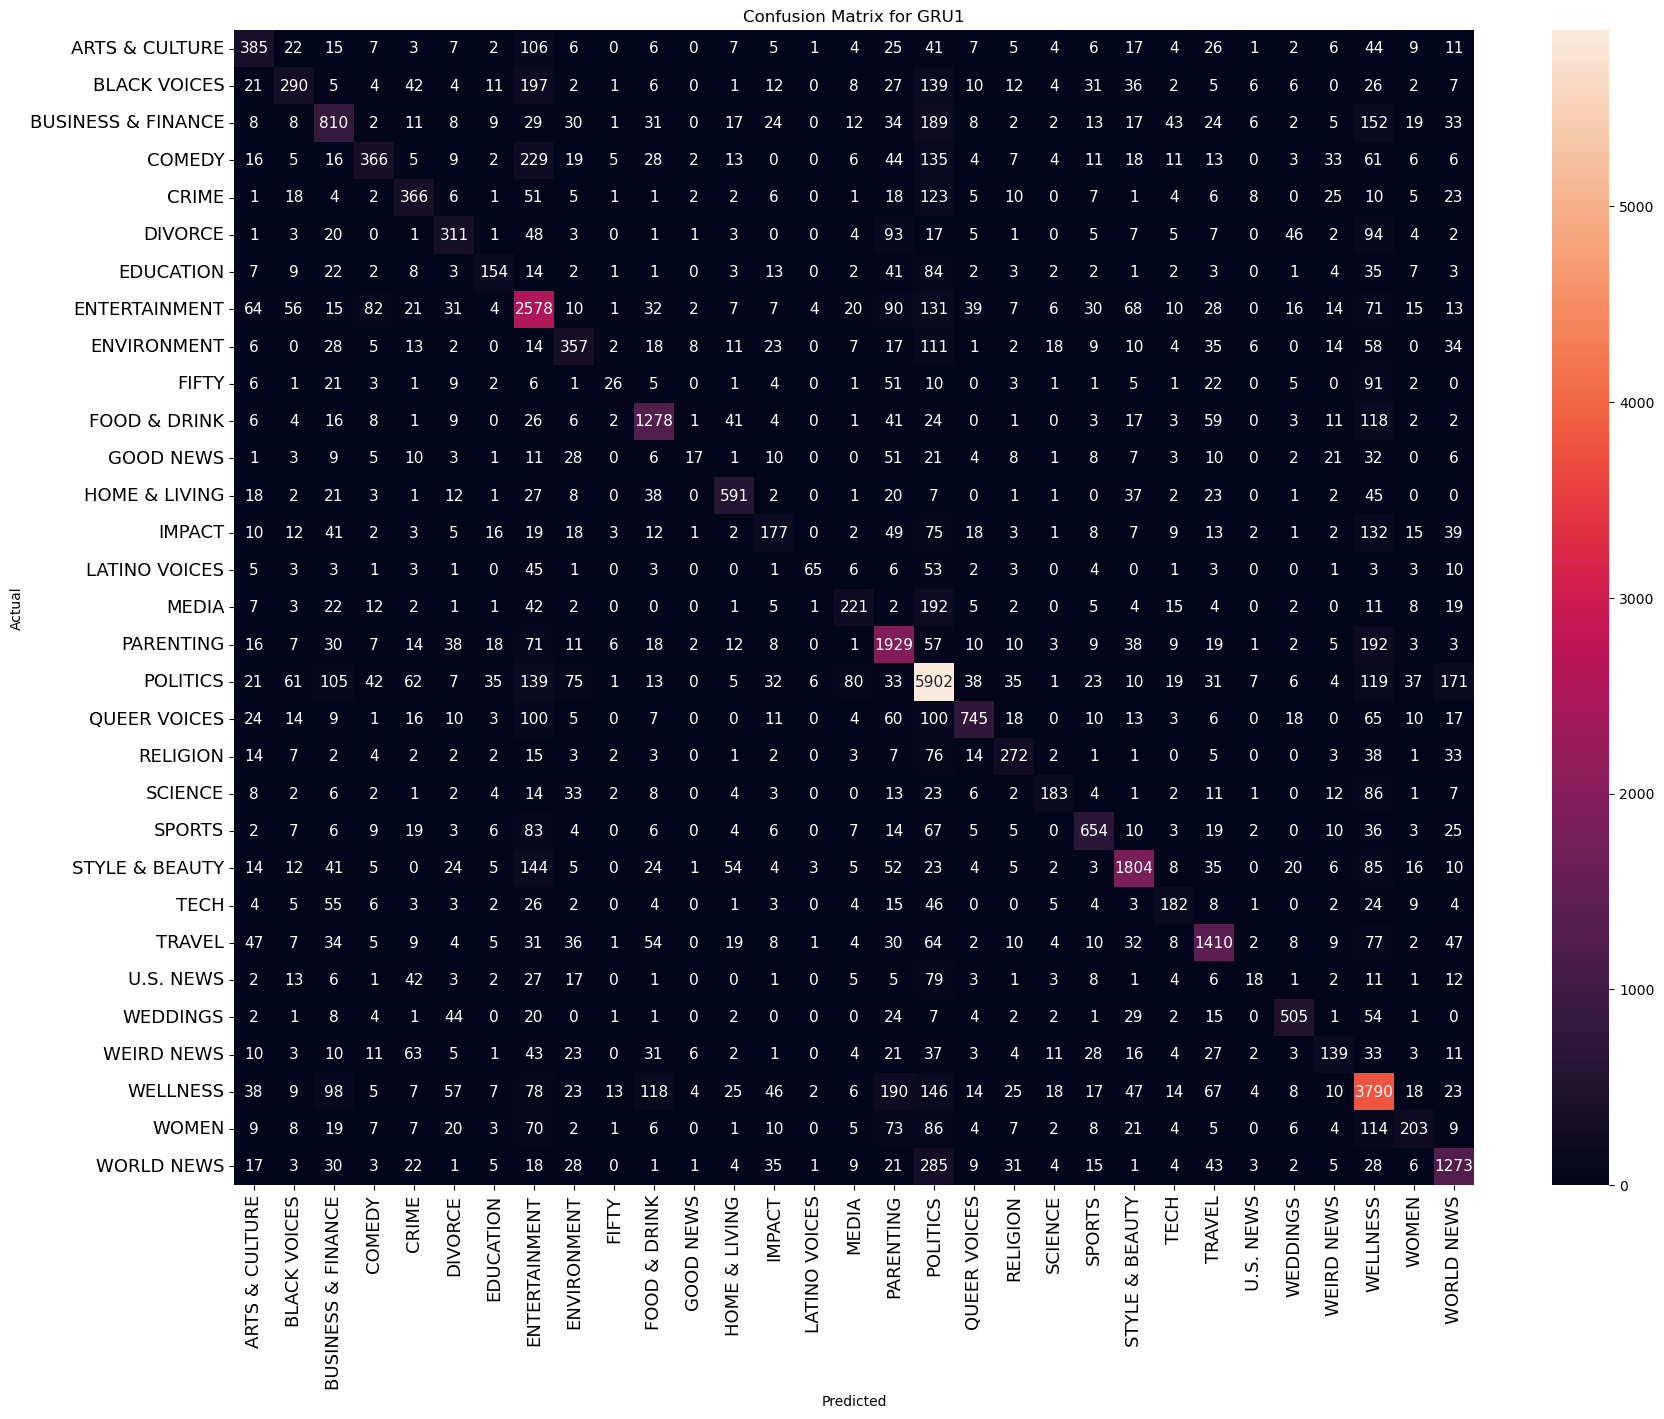

In [172]:
# Generate the confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes_lstm_glove, labels=sorted_labels)

# Plot the confusion matrix
plt.figure(figsize=(20, 15))
sns.heatmap(conf_matrix, annot=True, fmt="d", annot_kws={"size": 11},
            xticklabels=sorted_labels, yticklabels=sorted_labels, cmap="rocket")

# Set the plot configurations
plt.xticks(fontsize=13)
plt.yticks(fontsize=13) 
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix for GRU1')
plt.show()

**Summary for LSTM GloVe**  

Just as for GRU, GloVe proved to be about 5% less accurate than the standard setup. Word2Vec was also evaluated previously and had similar results.

### Display Classification Examples for the Best Model on the test set

The best model is gru1. The true classes on the test set will be comapred to the predicted labels.

In [173]:
# Create a data frame from the processed combined info column
test_df = pd.DataFrame(X_test, columns=['processed_combined_info'])

# Add the true labels
test_df['true_labels'] = true_classes

# Add the predicted labels from Model gru1
test_df['predicted_labels'] = predicted_classes_gru1

In [174]:
test_df.columns

Index(['processed_combined_info', 'true_labels', 'predicted_labels'], dtype='object')

In [247]:
# Pick 10 random samples
test_df.sample(n=12)

processed_combined_info  \
93279                                                                                                                                                     obama welcom athlet special olymp lo angel ap michel obama welcom thousand athlet special olymp world game lo angel   
204617                                                                                                                                  foreign tourist u hit record 2011 commerc depart say canada far 1 sourc foreign visitor 21 million follow mexico 13 4 million britain   
206836                                                                                                                                                           comedian live tweet oscar oscar night mean one thing us watch twitter feed obsess funniest snarkiest sarcast   
131969                                                                                                             learn mom held onto good thing taught love love love daughter prais attempt accomplish tell beauti talent bodi perfect special show worthi love cheer give   
134196                                                                                                                                                           moment realiz go miss cut master photo cut line later settl 4 par two round mickelson sent home earli master   
57326                                                                                                                                                                       support bereav young person lose somebodi love pain may even long term consequ may feel alon lost   
149506                                                                                                                          unlik inspir norway plan lower divorc rate scienc agre accord new york time report base studi done social psychologist arthur aron new experi   
149648                                                                   thing everi new mom know one tell matter mani parent book read mani niec nephew watch grow mani year clock babysit becom mom first time catapult entir foreign world could never fulli prepar expect   
133273  obama asian pivot worldpost review week u presid barack obama visit asia meet u alli assur america back china rise becom domin power region light west weak respons putin takeov crimea asian alli concern whether u stand steadi event conflict break one alli china   
24680                                                                                                                                                                                                      hot pink extra hot right proof rihanna hillari clinton steer wrong   
184322                                                                                                                            chip way healthi fall food think nice crispi chip part healthi diet think crisp fall air food form delici chip made season local grown food   
191825                                                                                                                                             kim kardashian hair revert pre kany look photo instagram went along tweet show kim k full face makeup old school hair even   

           true_labels predicted_labels  
93279           SPORTS           SPORTS  
204617          TRAVEL           TRAVEL  
206836          COMEDY           COMEDY  
131969       PARENTING        PARENTING  
134196          SPORTS         WELLNESS  
57326         WELLNESS         WELLNESS  
149506         DIVORCE          DIVORCE  
149648       PARENTING        PARENTING  
133273      WORLD NEWS         POLITICS  
24680   STYLE & BEAUTY    ENTERTAINMENT  
184322        WELLNESS     FOOD & DRINK  
191825  STYLE & BEAUTY   STYLE & BEAUTY

As stemming was used, many words are cut short to their stems making them look strange. It is interesting to see how the model predicted the classes. Some summaries are difficult for a human to classify.

### Conclusion

Merging several similar categories proved to be very successful in classifying the various categories. The implementation of RNNs also improved the classification accuracy over the baseline logistic regression model. For further details of the project please refer to the accompanying report.